# Predcition of Hospital Admission Related to Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_date_'+str(i), 'cough_ab_date_'+str(i), 'cough_ab_type_'+str(i),
                   'incdt_cough_date_'+str(i), 'admitted_cough_date_'+str(i), 'sgss_gp_cov_cough_date_'+str(i)]]
    
    #drop rows with no cough reord
    datum = datum[datum['cough_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_i
    datum = datum[datum['sgss_gp_cov_cough_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_date_'+str(i): 'cough_date', 'cough_ab_date_'+str(i): 'cough_ab_date', 
                           'cough_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_date_'+str(i): 'incdt_cough_date', 'incdt_cough_type_'+str(i): 'incdt_cough_type',
                           'admitted_cough_date_'+str(i): 'admitted_cough_date',
                           'sgss_gp_cov_cough_date_'+str(i): 'sgss_gp_cov_cough_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_cough_admitted', 'duration_cough_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]
    print(sum_betas_hazard[30].quantile(0.50))  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_cough/data_cough_record_cph_cough.txt", "w")
a.write("")
a.writelines(['data_cough_1 #with a record, #with no record: %.0f' % (data['cough_date_1'].notna().sum()), ', %.0f' % (data['cough_date_1'].isna().sum()),
              '\ndata_cough_2 #with a record, #with no record: %.0f' % (data['cough_date_2'].notna().sum()), ', %.0f' % (data['cough_date_2'].isna().sum()),
              '\ndata_cough_3 #with a record, #with no record: %.0f' % (data['cough_date_3'].notna().sum()), ', %.0f' % (data['cough_date_3'].isna().sum()),
              '\ndata_cough_4 #with a record, #with no record: %.0f' % (data['cough_date_4'].notna().sum()), ', %.0f' % (data['cough_date_4'].isna().sum()),
              '\ndata_cough_5 #with a record, #with no record: %.0f' % (data['cough_date_5'].notna().sum()), ', %.0f' % (data['cough_date_5'].isna().sum()),
              '\ndata_cough_6 #with a record, #with no record: %.0f' % (data['cough_date_6'].notna().sum()), ', %.0f' % (data['cough_date_6'].isna().sum()),
              '\ndata_cough_7 #with a record, #with no record: %.0f' % (data['cough_date_7'].notna().sum()), ', %.0f' % (data['cough_date_7'].isna().sum()),
              '\ndata_cough_8 #with a record, #with no record: %.0f' % (data['cough_date_8'].notna().sum()), ', %.0f' % (data['cough_date_8'].isna().sum()),
              '\ndata_cough_9 #with a record, #with no record: %.0f' % (data['cough_date_9'].notna().sum()), ', %.0f' % (data['cough_date_9'].isna().sum()),
              '\ndata_cough_10 #with a record, #with no record: %.0f' % (data['cough_date_10'].notna().sum()), ', %.0f' % (data['cough_date_10'].isna().sum()),
              '\ndata_cough_11 #with a record, #with no record: %.0f' % (data['cough_date_11'].notna().sum()), ', %.0f' % (data['cough_date_11'].isna().sum()),
              '\ndata_cough_12 #with a record, #with no record: %.0f' % (data['cough_date_12'].notna().sum()), ', %.0f' % (data['cough_date_12'].isna().sum()),
              '\ndata_cough_13 #with a record, #with no record: %.0f' % (data['cough_date_13'].notna().sum()), ', %.0f' % (data['cough_date_13'].isna().sum()),
              '\ndata_cough_14 #with a record, #with no record: %.0f' % (data['cough_date_14'].notna().sum()), ', %.0f' % (data['cough_date_14'].isna().sum()),
              '\ndata_cough_15 #with a record, #with no record: %.0f' % (data['cough_date_15'].notna().sum()), ', %.0f' % (data['cough_date_15'].isna().sum()),
              '\ndata_cough_16 #with a record, #with no record: %.0f' % (data['cough_date_16'].notna().sum()), ', %.0f' % (data['cough_date_16'].isna().sum()),
              '\ndata_cough_17 #with a record, #with no record: %.0f' % (data['cough_date_17'].notna().sum()), ', %.0f' % (data['cough_date_17'].isna().sum()),
              '\ndata_cough_18 #with a record, #with no record: %.0f' % (data['cough_date_18'].notna().sum()), ', %.0f' % (data['cough_date_18'].isna().sum()),
              '\ndata_cough_19 #with a record, #with no record: %.0f' % (data['cough_date_19'].notna().sum()), ', %.0f' % (data['cough_date_19'].isna().sum()),
              '\ndata_cough_20 #with a record, #with no record: %.0f' % (data['cough_date_20'].notna().sum()), ', %.0f' % (data['cough_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     36977
0.0     36852
2.0     33244
3.0     24811
4.0     15154
6.0     12202
7.0      9868
5.0      8346
8.0      7988
9.0      5740
10.0     3432
11.0     1910
12.0     1365
13.0      832
14.0      540
15.0      354
16.0      183
17.0      116
18.0       49
19.0       18
20.0       16
21.0        2
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 coughs and concatenate them 
data_cough_1 = proc_infec_data(data,1)
data_cough_2 = proc_infec_data(data,2)
data_cough_3 = proc_infec_data(data,3)
data_cough_4 = proc_infec_data(data,4)
data_cough_5 = proc_infec_data(data,5)
data_cough_6 = proc_infec_data(data,6)
data_cough_7 = proc_infec_data(data,7)
data_cough_8 = proc_infec_data(data,8)
data_cough_9 = proc_infec_data(data,9)
data_cough_10 = proc_infec_data(data,10)
data_cough_11 = proc_infec_data(data,11)
data_cough_12 = proc_infec_data(data,12)
data_cough_13 = proc_infec_data(data,13)
data_cough_14 = proc_infec_data(data,14)
data_cough_15 = proc_infec_data(data,15)
data_cough_16 = proc_infec_data(data,16)
data_cough_17 = proc_infec_data(data,17)
data_cough_18 = proc_infec_data(data,18)
data_cough_19 = proc_infec_data(data,19)
data_cough_20 = proc_infec_data(data,20)

data_cough = pd.concat([data_cough_1, data_cough_2, data_cough_3, data_cough_4, data_cough_5, data_cough_6, data_cough_7, data_cough_8, data_cough_9, data_cough_10, data_cough_11, data_cough_12, data_cough_13, data_cough_14, data_cough_15, data_cough_16, data_cough_17, data_cough_18, data_cough_19, data_cough_20])
data_cough.reset_index(inplace=True, drop=True)
data_cough.shape

(360064, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_cough['cough_date'] = data_cough['cough_date'].astype('datetime64[ns]')
data_cough['admitted_cough_date'] = data_cough['admitted_cough_date'].astype('datetime64[ns]')
data_cough.died_date = data_cough.died_date.astype('datetime64[ns]')
data_cough.deregistered_date = data_cough.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough['date'] = data_cough['cough_date'] #gp_cons_cough
data_cough['date'] = data_cough['date'].dt.strftime('%Y-%m')
print(f'min date: {data_cough.date.min()}')
print(f'max date: {data_cough.date.max()}')
print(f'length of data_cough: {len(data_cough)}')

min date: 2019-01
max date: 2022-11
length of data_cough: 360064


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_cough with today's date in year and month
data_cough = data_cough[data_cough['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough = data_cough[data_cough['date'] != last_1_month_date_y_m]
data_cough = data_cough[data_cough['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough records
data_cough['season'] = np.nan
data_cough['date_month'] = pd.DatetimeIndex(data_cough['date']).month

conditions = [
    (data_cough['date_month'] >= 3) & (data_cough['date_month'] <= 5),
    (data_cough['date_month'] >= 6) & (data_cough['date_month'] <= 8),
    (data_cough['date_month'] >= 9) & (data_cough['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough['season'] = np.select(conditions, choices, default='winter')

print(data_cough['season'].value_counts())
print(f'\nmin date: {data_cough.date.min()}')
print(f'max date: {data_cough.date.max()}')
print(f'length: {len(data_cough)}')

spring    93337
summer    93173
winter    83345
autumn    69291
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 339146


In [24]:
data_cough = data_cough[data_cough['date'] <= '2019-12']
# data_cough = data_cough[(data_cough['date'] >= '2020-03') & (data_cough['date']<= '2021-03')]
# data_cough = data_cough[data_cough['date'] >= '2021-04']
# print(f'min date: {data_cough.date.min()}')
# print(f'max date: {data_cough.date.max()}')

In [25]:
#add period variable
data_cough.loc[(data_cough['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough.loc[((data_cough['date'] >= '2020-01') & (data_cough['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough.loc[(data_cough['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [26]:
#scenario 1
#not hosped (nothing happened)
#data_cough = data_cough[data_cough['admitted_cough_date'].notnull()]
data_cough.loc[data_cough['admitted_cough_date'].isnull(), 'event_cough_admitted'] = 0
data_cough['event_cough_admitted'].value_counts()

0.0    237690
Name: event_cough_admitted, dtype: int64

In [27]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_cough['delta_cough_admitted'] = (data_cough['admitted_cough_date'] - data_cough['cough_date']).dt.days
data_cough['delta_cough_admitted'] = (data_cough['admitted_cough_date'] - data_cough['cough_date']).dt.days #gp_cons_cough
data_cough.loc[((data_cough['delta_cough_admitted'] >= 0) & (data_cough['delta_cough_admitted'] <= 30)), 'event_cough_admitted'] = 1
# data_cough['event_cough_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before cough consultation, i.e. negative value for delta_cough_admitted
data_cough = data_cough[~(data_cough['delta_cough_admitted'] < 0)]
data_cough['delta_cough_admitted'].value_counts()

44.0      92
66.0      91
93.0      87
259.0     86
164.0     85
          ..
1401.0     1
1381.0     1
1349.0     1
1397.0     1
1406.0     1
Name: delta_cough_admitted, Length: 1396, dtype: int64

In [28]:
#scenario 3
#censor died patients
data_cough['delta_admitted_died'] = (data_cough['died_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_cough.loc[data_cough['delta_admitted_died'] >= 0, 'event_cough_admitted'] = 0
data_cough.loc[((data_cough['delta_admitted_died'] >= 0) & (data_cough['delta_admitted_died'] <= 30)), 'event_cough_admitted'] = 0
# data_cough['event_cough_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_cough['delta_admitted_deregistered'] = (data_cough['deregistered_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_cough.loc[data_cough['delta_admitted_deregistered'] >= 0, 'event_cough_admitted'] = 0
data_cough.loc[((data_cough['delta_admitted_deregistered'] > 0) & (data_cough['delta_admitted_deregistered'] <= 30)), 'event_cough_admitted'] = 0
# data_cough['event_cough_admitted'].value_counts()

#agg scenario 3s
data_cough['delta_admitted_died_deregistered'] = data_cough['delta_admitted_deregistered'].combine_first(data_cough['delta_admitted_died'])
data_cough.loc[data_cough['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_cough['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

286352

In [29]:
#scenario 1
#any other patients (nothing happened)
data_cough['event_cough_admitted'] = data_cough['event_cough_admitted'].replace(np.NaN, 0)
data_cough['event_cough_admitted'].value_counts()

0.0    289324
1.0      2214
Name: event_cough_admitted, dtype: int64

In [30]:
#assign values for duration column
data_cough['duration_cough_admitted'] = data_cough['delta_cough_admitted'].combine_first(data_cough['delta_admitted_died_deregistered'])
data_cough['duration_cough_admitted'] = data_cough['duration_cough_admitted'].replace(np.NaN, 30)
data_cough.loc[(data_cough['duration_cough_admitted'] > 30), 'duration_cough_admitted'] = 30
data_cough['duration_cough_admitted'].value_counts()

30.0    289397
4.0         84
7.0         83
1.0         82
28.0        82
10.0        81
12.0        80
9.0         80
13.0        79
16.0        78
11.0        77
20.0        77
3.0         77
0.0         74
5.0         74
25.0        72
18.0        71
21.0        71
8.0         71
14.0        70
26.0        68
24.0        67
15.0        66
27.0        65
23.0        62
19.0        62
22.0        62
6.0         58
2.0         58
29.0        57
17.0        53
Name: duration_cough_admitted, dtype: int64

In [31]:
# give value 1 to event_cough_admitted if duration_cough_admitted is greater or equal to 0 and less than 30
data_cough.loc[((data_cough['duration_cough_admitted'] >= 0) & (data_cough['duration_cough_admitted'] < 30)), 'event_cough_admitted'] = 1
data_cough['event_cough_admitted'].value_counts()

0.0    289321
1.0      2217
Name: event_cough_admitted, dtype: int64

In [32]:
#drop any rows with value 0 in duration column
data_cough = data_cough[~(data_cough['duration_cough_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough.loc[((data_cough['delta_cough_admitted'] > 0) & (data_cough['delta_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

In [33]:
# data_cough[data_cough['duration_cough_admitted']==0][['delta_cough_admitted', 'cough_date', 'gp_cons_cough', 'admitted_cough_date', 'delta_cough_admitted', 'delta_admitted_died_deregistered', 'event_cough_admitted', 'duration_cough_admitted']]
# data_cough.loc[151:200, ['event_cough_admitted', 'duration_cough_admitted']]
# data_cough.loc[201:250, ['event_cough_admitted', 'duration_cough_admitted']].sort_values(by=['duration_cough_admitted'])
data_cough[['event_cough_admitted', 'duration_cough_admitted']].sort_values(by=['duration_cough_admitted'])

,event_cough_admitted,duration_cough_admitted
115547,1.0,1.0
340088,1.0,1.0
336256,1.0,1.0
61008,1.0,1.0
341460,1.0,1.0
...,...,...
120522,0.0,30.0
120521,0.0,30.0
120520,0.0,30.0
120528,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [34]:
# prep before plot
data_cough['age'][data_cough['age'] < 0] = np.nan
data_cough = data_cough[data_cough['age_cat'] != '0-4']
data_cough = data_cough[data_cough['age_cat'] != '5-14']
# drop anybody with age less than 18
data_cough = data_cough[~(data_cough['age'] < 18)]  
print(f'Min age: {data_cough.age.min()}')

## remove died cases
#data_cough.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_cough['bmi'][data_cough['bmi'] < 10] = 0
# replace 0s with nans
data_cough['bmi'] = data_cough['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_cough['antibacterial_brit'][data_cough['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [35]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough = data_cough.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_cough = data_cough.replace({"smoking_status": dict_smoking})

In [36]:
if ('region' in data_cough.columns) and (data_cough['region'].isnull().sum() > 0):
    # drop region value missing
    # data_cough['region_imp'] = data_cough['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_cough.region.isnull().sum()}')
    data_cough = data_cough[data_cough['region'].notna()]

print(f'Cound of missing values in variable region: {data_cough.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_cough.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35081
Yorkshire and The Humber    18090
North East                  18000
East Midlands               17815
West Midlands               17712
North West                  17699
South West                  17691
South East                  17372
East                        17263
Name: region, dtype: int64


In [37]:
if ('antibacterial_brit' in data_cough.columns) and (data_cough['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_cough.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_cough.antibacterial_brit.mean():.3f}')
    data_cough['antibacterial_brit'] = data_cough['antibacterial_brit'].fillna(0)
    # data_cough['antibacterial_brit'] = data_cough['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_cough.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_cough.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 3
Mean of antibacterial_brit values before changing NAN to zeros: 1.247

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.247


In [38]:
if ('ethnicity' in data_cough.columns) and (data_cough['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_cough.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_cough.ethnicity.value_counts()}')
    # data_cough['ethnicity'] = data_cough['ethnicity'].astype(str)
    data_cough['ethnicity'] = data_cough['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_cough.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_cough.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 43905
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    106081
5.0     13423
3.0     13314
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    106081
0.0     43905
5.0     13423
3.0     13314
Name: ethnicity, dtype: int64


In [39]:
if ('smoking_status' in data_cough.columns) and (data_cough['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_cough.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_cough.smoking_status.value_counts()}')
    # data_cough['smoking_status'] = data_cough['smoking_status'].astype(str)
    data_cough['smoking_status'] = data_cough['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_cough.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_cough.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73337
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    68955
3.0    23017
2.0    11414
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73337
1.0    68955
3.0    23017
2.0    11414
Name: smoking_status, dtype: int64


In [40]:
if ('imd' in data_cough.columns) and (data_cough['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_cough.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_cough.imd.value_counts()}')
    # data_cough['imd'] = data_cough['imd'].astype(str)
    data_cough['imd'] = data_cough['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_cough.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_cough.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    33774
5    33656
2    33602
4    33337
1    33252
0     9102
Name: imd, dtype: int64


In [41]:
data_cough['bmi_cat'] = 5
col_bmi_cat = data_cough.columns.get_loc('bmi_cat')

col_sex = data_cough.columns.get_loc('sex')
col_age = data_cough.columns.get_loc('age')
col_bmi = data_cough.columns.get_loc('bmi')

for idx, x in enumerate(data_cough['bmi_cat']):
    if data_cough.iat[idx, col_bmi] >= 30:
        data_cough.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_cough.iat[idx, col_bmi] >= 25) and (data_cough.iat[idx, col_bmi] < 30):
        data_cough.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_cough.iat[idx, col_bmi] >= 18.5) and (data_cough.iat[idx, col_bmi] < 25):
        data_cough.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_cough.iat[idx, col_bmi] < 18.5:
        data_cough.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_cough['bmi_cat'].value_counts()

1    90819
5    45445
2    20184
3    14456
4     5819
Name: bmi_cat, dtype: int64

In [42]:
if ('bmi_cat' in data_cough.columns) and (data_cough['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_cough.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_cough.bmi_cat.value_counts()}')
    # data_cough['bmi_cat'] = data_cough['bmi_cat'].astype(str)
    data_cough['bmi_cat'] = data_cough['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_cough.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_cough.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    90819
5    45445
2    20184
3    14456
4     5819
Name: bmi_cat, dtype: int64


In [43]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_cough.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough['ab_type_cat'] = np.where(data_cough['ab_type'].isin(ab_series[mask].index),'other',data_cough['ab_type'])

#assign no to non ab users
data_cough.loc[data_cough['cough_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_cough['ab_type_cat'] = data_cough['ab_type_cat'].fillna(0)
data_cough['ab_type_cat'].value_counts()

no             159073
0               14133
other            2146
Amoxicillin      1003
Doxycycline       368
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [44]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [45]:
# reoplace values of dictionaries with existing ones
data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"ethnicity": dict_ethnicity})
data_cough = data_cough.replace({"smoking_status": dict_smoking})
data_cough = data_cough.replace({"imd": dict_imd})
data_cough = data_cough.replace({"bmi_cat": dict_bmi})
data_cough = data_cough.replace({"flu_vaccine": dict_flu})
data_cough = data_cough.replace({"region": dict_region})
data_cough = data_cough.replace({"age_cat": dict_age})
data_cough = data_cough.replace({"ab_type_cat": dict_ab_type})
data_cough['ab_type_cat'].value_counts()

no             159073
other           16279
Amoxicillin      1003
Doxycycline       368
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [46]:
# categorising
data_cough['CCI_cat'] = pd.cut(data_cough['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_cough['CCI_cat'].value_counts()

low          62084
medium       35488
very_low     32604
very_high    28514
high         18033
Name: CCI_cat, dtype: int64

In [47]:
# assign max value to outliers (beyond 95 percentile)
data_cough['antibacterial_brit'].clip(0, data_cough['antibacterial_brit'].quantile(0.95), inplace=True)
data_cough['antibacterial_brit'].max()

data_cough['antibacterial_brit_cat'] = pd.cut(data_cough['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_cough['antibacterial_brit_cat'].value_counts()

low       102563
high       43966
medium     30194
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

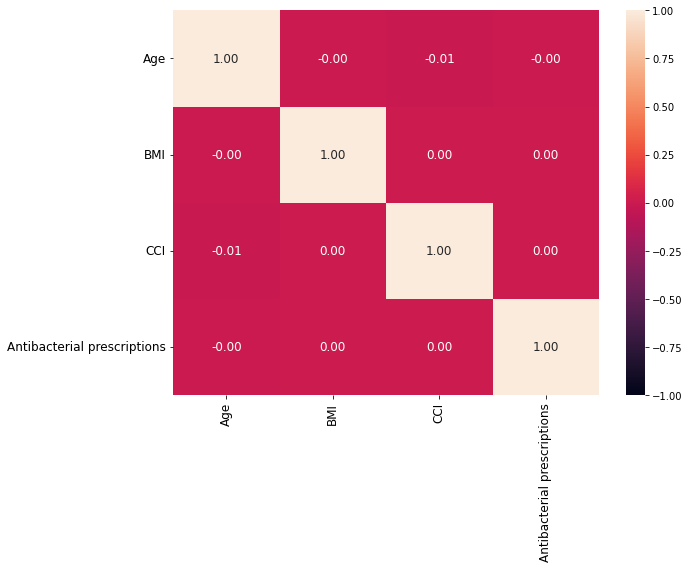

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_cough[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough/corr_cough.jpg')
plt.show()

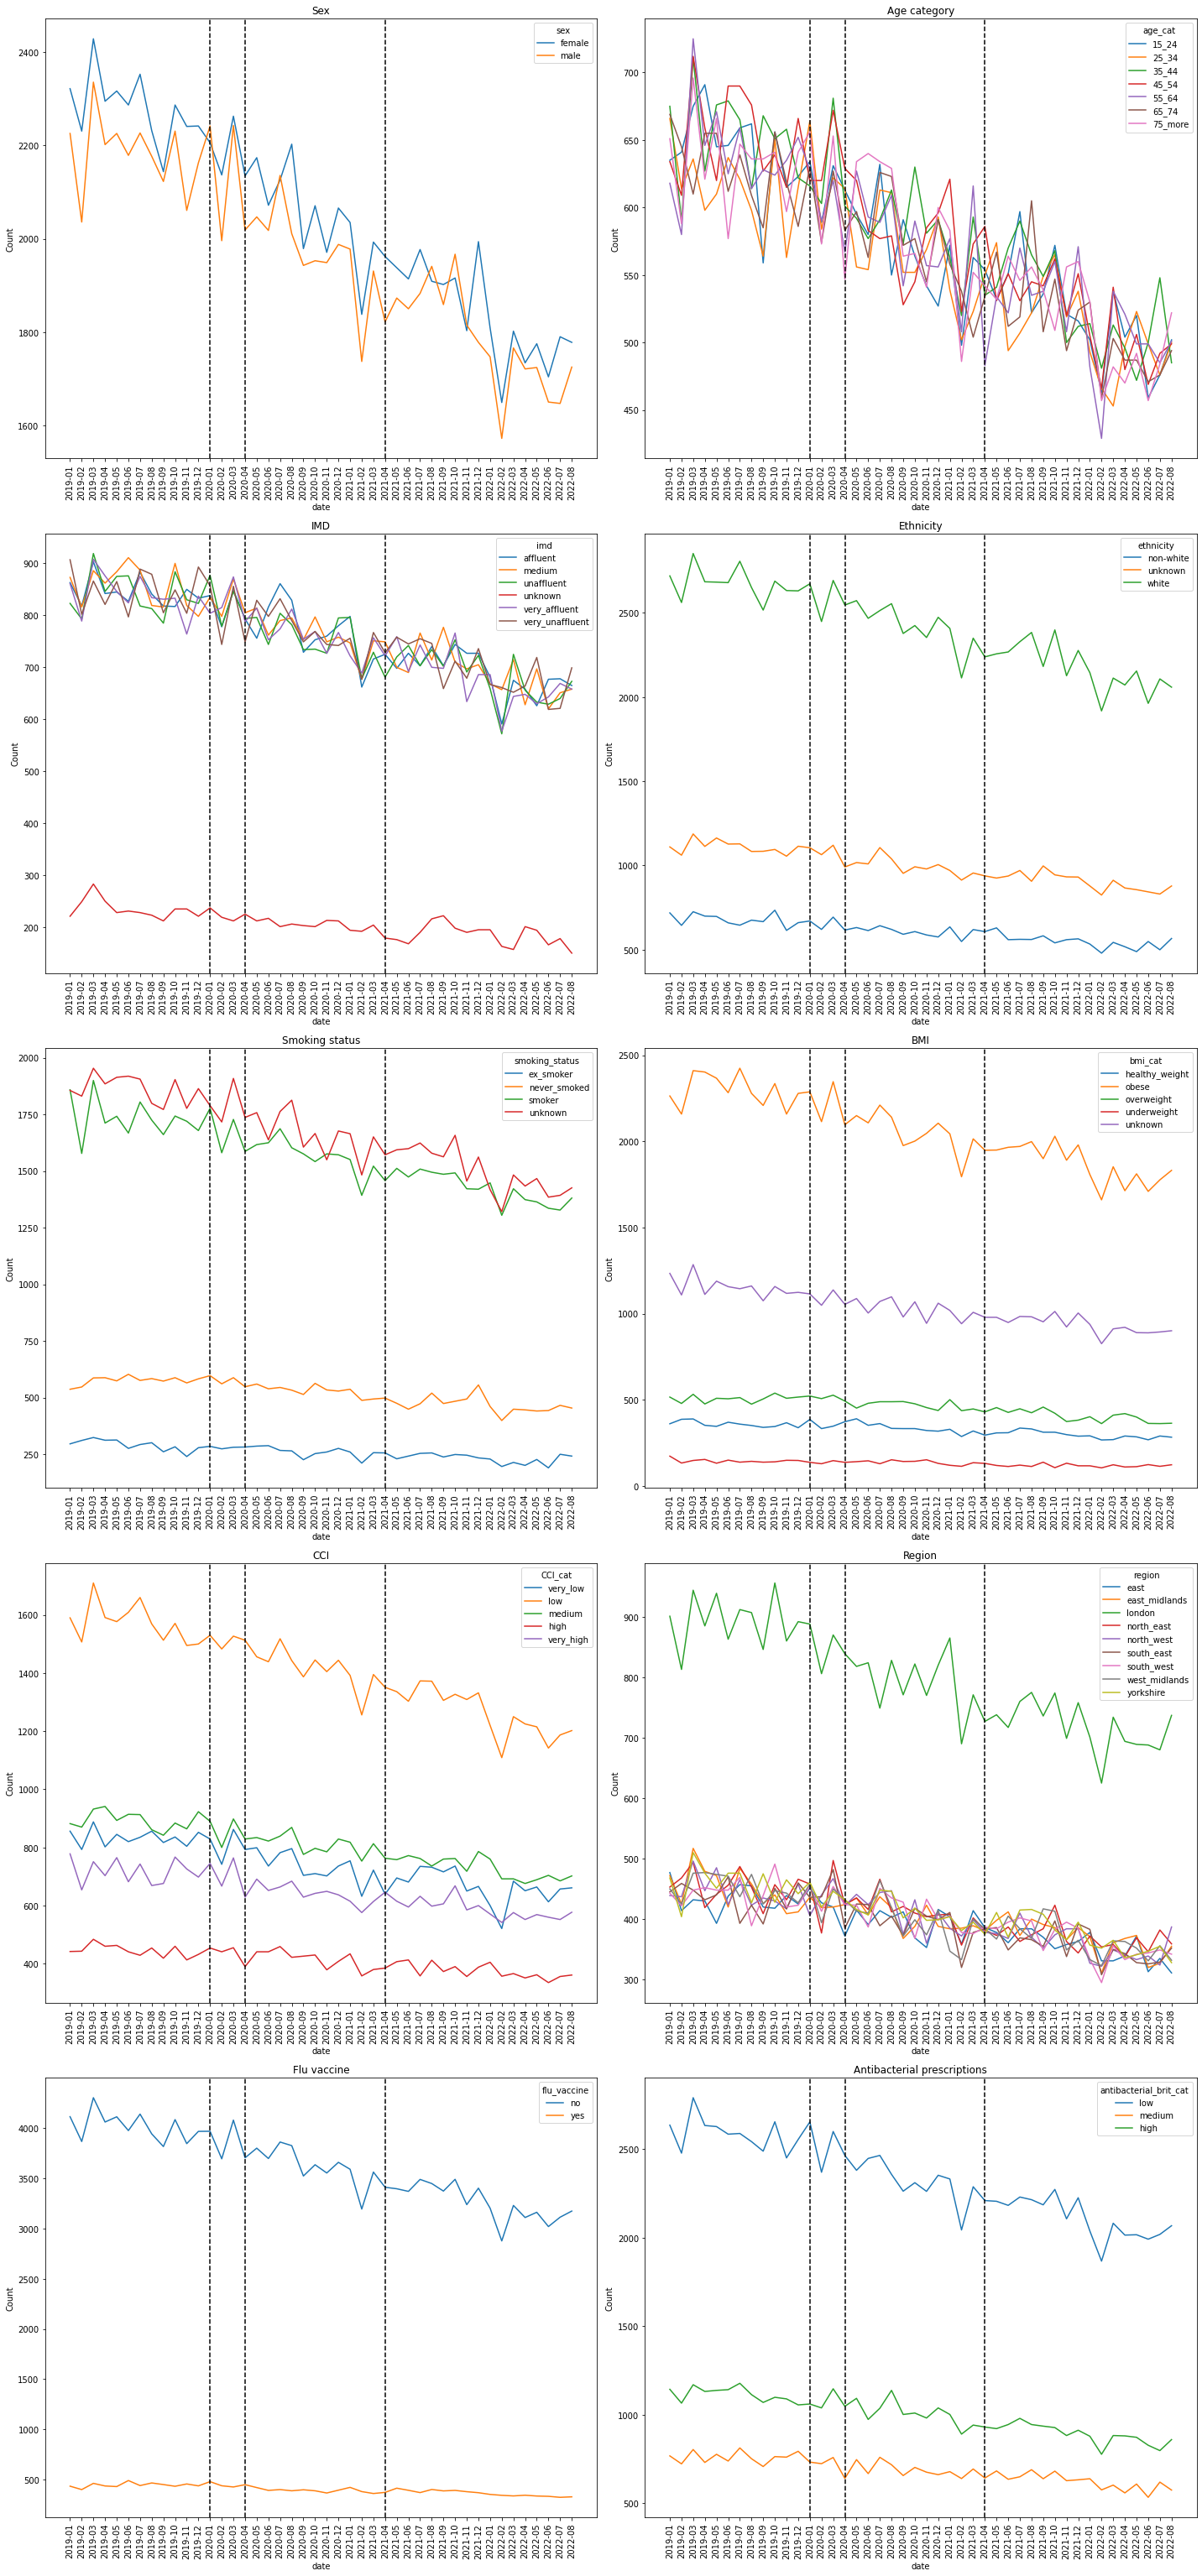

In [49]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_cough, 'sex', 'Sex', axes[0,0])
create_lineplot(data_cough, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_cough, 'imd', 'IMD', axes[1,0])
create_lineplot(data_cough, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_cough, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_cough, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_cough, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_cough, 'region', 'Region', axes[3,1])
create_lineplot(data_cough, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_cough, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of cough patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough/risk_factors_cat_cough.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of cough to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [50]:
data_cough = data_cough[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'cough_ab_date', 'ab_type_cat', 'incdt_cough_date', 'date', 'period',
                       'event_cough_admitted', 'duration_cough_admitted'
                        ]]

data_cough.shape

(176723, 18)

In [51]:
#incident and prevalent infection 
data_cough_incdt = data_cough[data_cough['incdt_cough_date'] == 0]
data_cough_prevl = data_cough[data_cough['incdt_cough_date'] == 1]
#switch variable cough_ab_date into a binary variable
data_cough_incdt[['cough_ab_date']] = data_cough_incdt[['cough_ab_date']].where(data_cough_incdt[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)
data_cough_prevl[['cough_ab_date']] = data_cough_prevl[['cough_ab_date']].where(data_cough_prevl[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_cough_incdt_males = data_cough_incdt[data_cough_incdt['sex'] == 'male']
data_cough_incdt_females = data_cough_incdt[data_cough_incdt['sex'] == 'female']
data_cough_prevl_males = data_cough_prevl[data_cough_prevl['sex'] == 'male']
data_cough_prevl_females = data_cough_prevl[data_cough_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_cough_incdt_15_24 = data_cough_incdt[data_cough_incdt['age_cat'] == '15_24']
data_cough_incdt_25_34 = data_cough_incdt[data_cough_incdt['age_cat'] == '25_34']
data_cough_incdt_35_44 = data_cough_incdt[data_cough_incdt['age_cat'] == '35_44']
data_cough_incdt_45_54 = data_cough_incdt[data_cough_incdt['age_cat'] == '45_54']
data_cough_incdt_55_64 = data_cough_incdt[data_cough_incdt['age_cat'] == '55_64']
data_cough_incdt_65_74 = data_cough_incdt[data_cough_incdt['age_cat'] == '65_74']
data_cough_incdt_75_more = data_cough_incdt[data_cough_incdt['age_cat'] == '75_more']
data_cough_prevl_15_24 = data_cough_prevl[data_cough_prevl['age_cat'] == '15_24']
data_cough_prevl_25_34 = data_cough_prevl[data_cough_prevl['age_cat'] == '25_34']
data_cough_prevl_35_44 = data_cough_prevl[data_cough_prevl['age_cat'] == '35_44']
data_cough_prevl_45_54 = data_cough_prevl[data_cough_prevl['age_cat'] == '45_54']
data_cough_prevl_55_64 = data_cough_prevl[data_cough_prevl['age_cat'] == '55_64']
data_cough_prevl_65_74 = data_cough_prevl[data_cough_prevl['age_cat'] == '65_74']
data_cough_prevl_75_more = data_cough_prevl[data_cough_prevl['age_cat'] == '75_more']

data_cough_incdt_prepandemic = data_cough_incdt[data_cough_incdt['date'] <= '2019-12']
data_cough_incdt_during_pandemic = data_cough_incdt[(data_cough_incdt['date'] >= '2020-03') & (data_cough_incdt['date']<= '2021-03')]
data_cough_incdt_post_2nd_lockdown = data_cough_incdt[data_cough_incdt['date'] <= '2021-04']
data_cough_prevl_prepandemic = data_cough_prevl[data_cough_prevl['date'] <= '2019-12']
data_cough_prevl_during_pandemic = data_cough_prevl[(data_cough_prevl['date'] >= '2020-03') & (data_cough_prevl['date']<= '2021-03')]
data_cough_prevl_post_2nd_lockdown = data_cough_prevl[data_cough_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_cough_incdt_abtype_0 = data_cough_incdt[data_cough_incdt['ab_type_cat'] == data_cough['ab_type_cat'].unique()[0]]
# data_cough_incdt_abtype_1 = data_cough_incdt[data_cough_incdt['ab_type_cat'] == data_cough['ab_type_cat'].unique()[1]]
# data_cough_incdt_abtype_2 = data_cough_incdt[data_cough_incdt['ab_type_cat'] == data_cough['ab_type_cat'].unique()[2]]
# data_cough_incdt_abtype_3 = data_cough_incdt[data_cough_incdt['ab_type_cat'] == data_cough['ab_type_cat'].unique()[3]]
# data_cough_prevl_abtype_0 = data_cough_prevl[data_cough_prevl['ab_type_cat'] == data_cough['ab_type_cat'].unique()[0]]
# data_cough_prevl_abtype_1 = data_cough_prevl[data_cough_prevl['ab_type_cat'] == data_cough['ab_type_cat'].unique()[1]]
# data_cough_prevl_abtype_2 = data_cough_prevl[data_cough_prevl['ab_type_cat'] == data_cough['ab_type_cat'].unique()[2]]
# data_cough_prevl_abtype_3 = data_cough_prevl[data_cough_prevl['ab_type_cat'] == data_cough['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_cough_incdt_abs = data_cough_incdt[data_cough_incdt['cough_ab_date'] == 1]
# data_cough_prevl_abs = data_cough_prevl[data_cough_prevl['cough_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_cough_no_abs_incdt = data_cough[data_cough['cough_ab_date'].isnull()] #gp_cons_cough_ab
data_cough_no_abs_incdt = data_cough_no_abs_incdt[data_cough_no_abs_incdt['incdt_cough_date'] == 0]

# with antibiotics and incident hospital admission
data_cough_abs_incdt = data_cough[data_cough['cough_ab_date'].notnull()]
data_cough_abs_incdt = data_cough_abs_incdt[data_cough_abs_incdt['incdt_cough_date'] == 0]

# no antibiotics and prevalent hospital admission
data_cough_no_abs_prevl = data_cough[data_cough['cough_ab_date'].isnull()]
data_cough_no_abs_prevl = data_cough_no_abs_prevl[data_cough_no_abs_prevl['incdt_cough_date'] == 1]

# with antibiotics and prevalent hospital admission
data_cough_abs_prevl = data_cough[data_cough['cough_ab_date'].notnull()]
data_cough_abs_prevl = data_cough_abs_prevl[data_cough_abs_prevl['incdt_cough_date'] == 1]

print(f'shape of data_cough_incdt: {data_cough_incdt.shape}')
print(f'shape of data_cough_prevl: {data_cough_prevl.shape}')
print(f'shape of data_cough_no_abs_incdt: {data_cough_no_abs_incdt.shape}')
print(f'shape of data_cough_abs_incdt: {data_cough_abs_incdt.shape}')
print(f'shape of data_cough_no_abs_prevl: {data_cough_no_abs_prevl.shape}')
print(f'shape of data_cough_abs_prevl: {data_cough_abs_prevl.shape}')
print(f'\nvalue counts of data_cough_no_abs_incdt: \n{data_cough_no_abs_incdt.event_cough_admitted.value_counts()}')
print(f'value counts of data_cough_abs_incdt: \n{data_cough_abs_incdt.event_cough_admitted.value_counts()}')
print(f'value counts of data_cough_no_abs_prevl: \n{data_cough_no_abs_prevl.event_cough_admitted.value_counts()}')
print(f'value counts of data_cough_abs_prevl: \n{data_cough_abs_prevl.event_cough_admitted.value_counts()}')

shape of data_cough_incdt: (159041, 18)
shape of data_cough_prevl: (17682, 18)
shape of data_cough_no_abs_incdt: (143131, 18)
shape of data_cough_abs_incdt: (15910, 18)
shape of data_cough_no_abs_prevl: (15942, 18)
shape of data_cough_abs_prevl: (1740, 18)

value counts of data_cough_no_abs_incdt: 
0.0    142050
1.0      1081
Name: event_cough_admitted, dtype: int64
value counts of data_cough_abs_incdt: 
0.0    15817
1.0       93
Name: event_cough_admitted, dtype: int64
value counts of data_cough_no_abs_prevl: 
0.0    15829
1.0      113
Name: event_cough_admitted, dtype: int64
value counts of data_cough_abs_prevl: 
0.0    1725
1.0      15
Name: event_cough_admitted, dtype: int64


In [52]:
#store data for plotting hosp admission counts and percentages
%store data_cough
# save data
data_cough.to_csv('../output/hospitalisation_prediction_cough/data_cough.csv')

Stored 'data_cough' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident cough with no antibiotics

<lifelines.CoxPHFitter: fitted with 107348 total observations, 106533 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 107348
number of events observed = 815
   partial log-likelihood = -9425.96
         time fit was run = 2022-11-22 17:10:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.10            -0.29             0.10                 0.75                 1.10
CCI_cat[T.medium]               -0.11       0.90       0.11            -0.33             0.11                 0.72                 1.11
CCI_cat[T.high]                 -0.20       0.82       0.14            -0.47             0.08                 0.62                 1.08
CCI_cat[T.very_high]            -0.07       0.93       0.12            -0.30             0.15                 0.74                 1.17
age_cat[T.25_34]                -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
age_cat[T.35_44]                -0.08       0.93       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.45_54]                -0.14       0.87       0.13            -0.40             0.12                 0.67                 1.13
age_cat[T.55_64]                 0.11       1.12       0.13            -0.13             0.36                 0.88                 1.44
age_cat[T.65_74]                -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.75_more]               0.08       1.08       0.13            -0.17             0.32                 0.84                 1.38
antibacterial_brit               0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                -0.08       0.92       0.13            -0.33             0.16                 0.72                 1.18
bmi_cat[T.overweight]           -0.00       1.00       0.15            -0.30             0.30                 0.74                 1.35
bmi_cat[T.underweight]          -0.13       0.88       0.23            -0.58             0.31                 0.56                 1.37
bmi_cat[T.unknown]              -0.21       0.81       0.14            -0.48             0.06                 0.62                 1.06
ethnicity[T.unknown]             0.05       1.05       0.12            -0.17             0.28                 0.84                 1.32
ethnicity[T.white]               0.06       1.06       0.10            -0.14             0.26                 0.87                 1.30
flu_vaccine[T.yes]               0.00       1.00       0.12            -0.23             0.23                 0.80                 1.26
imd[T.medium]                   -0.04       0.96       0.11            -0.27             0.19                 0.77                 1.20
imd[T.unaffluent]               -0.04       0.96       0.12            -0.26             0.19                 0.77                 1.21
imd[T.unknown]                   0.03       1.03       0.17            -0.31             0.37                 0.74                 1.45
imd[T.very_affluent]             0.06       1.06       0.11            -0.16             0.28                 0.85                 1.32
imd[T.very_unaffluent]           0.03       1.03       0.11            -0.19             0.25                 0.82                 1.28
region[T.east_midlands]          0.15       1.17       0.16            -0.15             0.46                 0.86                 1.59
region[T.london]                -0.02       0.98       0.14    

12774


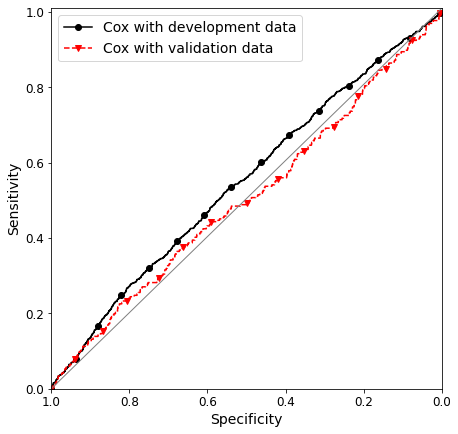

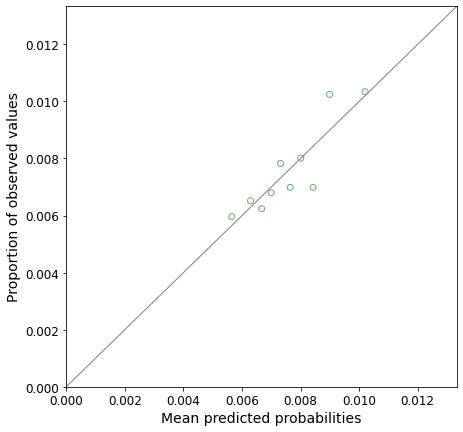

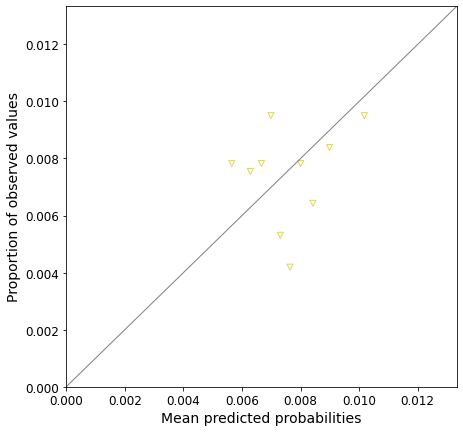

In [53]:
#data prep
data, data_cough_no_abs_incdt_enc = cox_data_prep(data_cough_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'no_abs_incdt', data_cough_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'no_abs_incdt', data_cough_no_abs_incdt)

try:
    #build cox model 
    cph_cough_no_abs_incdt, data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test = cox_model_build('cough', 'no_abs_incdt', data_cough_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_no_abs_incdt, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_no_abs_incdt.csv', data_cough_no_abs_incdt_enc, data_cough_no_abs_incdt, 'sum_betas_cph_cough_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_no_abs_incdt, 'event_cough_admitted', data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_no_abs_incdt, data_cough_no_abs_incdt_train, 'event_cough_admitted', data_cough_no_abs_incdt_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_no_abs_incdt_train.jpg', 'calibration_cph_cough_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_no_abs_incdt, 'cough', 'no_abs_incdt', data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident cough with antibiotics

<lifelines.CoxPHFitter: fitted with 11932 total observations, 11860 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 11932
number of events observed = 72
   partial log-likelihood = -653.85
         time fit was run = 2022-11-22 17:11:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.36            -0.52             0.88                 0.60                 2.41
CCI_cat[T.medium]               -0.12       0.88       0.43            -0.96             0.71                 0.38                 2.04
CCI_cat[T.high]                  0.28       1.33       0.45            -0.60             1.17                 0.55                 3.21
CCI_cat[T.very_high]             0.26       1.30       0.41            -0.54             1.07                 0.58                 2.91
age_cat[T.25_34]                 0.52       1.68       0.48            -0.41             1.45                 0.66                 4.28
age_cat[T.35_44]                -0.87       0.42       0.69            -2.22             0.48                 0.11                 1.62
age_cat[T.45_54]                 0.12       1.12       0.52            -0.90             1.13                 0.41                 3.10
age_cat[T.55_64]                 0.76       2.15       0.45            -0.13             1.65                 0.88                 5.22
age_cat[T.65_74]                 0.76       2.14       0.46            -0.14             1.66                 0.87                 5.27
age_cat[T.75_more]               0.44       1.55       0.48            -0.51             1.39                 0.60                 4.01
antibacterial_brit               0.14       1.15       0.08            -0.02             0.30                 0.98                 1.34
bmi_cat[T.obese]                -0.01       0.99       0.44            -0.88             0.85                 0.42                 2.34
bmi_cat[T.overweight]           -0.23       0.79       0.56            -1.32             0.86                 0.27                 2.37
bmi_cat[T.underweight]         -15.79       0.00    1883.62         -3707.61          3676.03                 0.00                  inf
bmi_cat[T.unknown]               0.17       1.18       0.46            -0.74             1.07                 0.48                 2.93
ethnicity[T.unknown]            -0.21       0.81       0.36            -0.91             0.49                 0.40                 1.63
ethnicity[T.white]              -0.31       0.74       0.31            -0.92             0.30                 0.40                 1.35
flu_vaccine[T.yes]              -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.06
imd[T.medium]                   -0.17       0.84       0.39            -0.94             0.60                 0.39                 1.82
imd[T.unaffluent]               -0.06       0.95       0.39            -0.81             0.70                 0.44                 2.02
imd[T.unknown]                  -0.71       0.49       0.76            -2.19             0.78                 0.11                 2.17
imd[T.very_affluent]            -0.08       0.92       0.39            -0.84             0.67                 0.43                 1.96
imd[T.very_unaffluent]           0.17       1.19       0.36            -0.53             0.87                 0.59                 2.40
region[T.east_midlands]          1.10       3.01       0.67            -0.21             2.41                 0.81                11.13
region[T.london]                 0.84       2.31       0.64         

12772


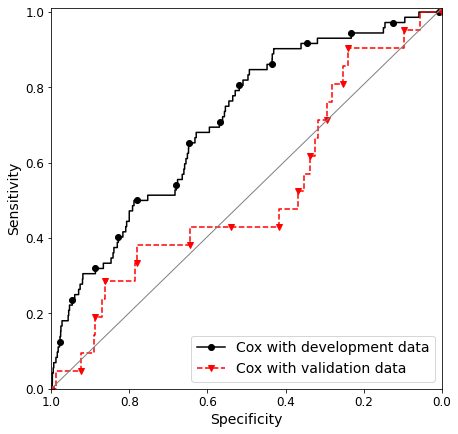

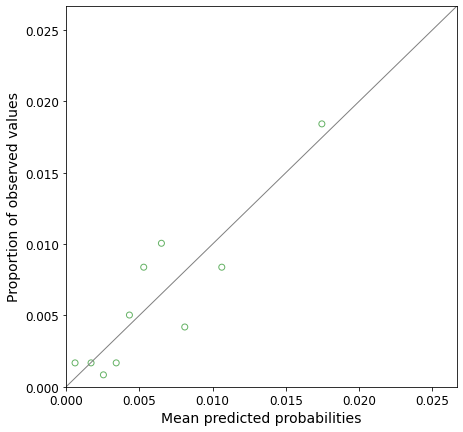

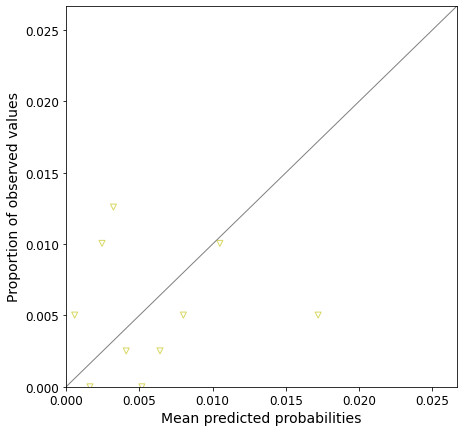

In [54]:
#data prep
data, data_cough_abs_incdt_enc = cox_data_prep(data_cough_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'abs_incdt', data_cough_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'abs_incdt', data_cough_abs_incdt)

try:
    #build cox model 
    cph_cough_abs_incdt, data_cough_abs_incdt_train, data_cough_abs_incdt_test = cox_model_build('cough', 'abs_incdt', data_cough_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_abs_incdt, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_abs_incdt.csv', data_cough_abs_incdt_enc, data_cough_abs_incdt, 'sum_betas_cph_cough_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_abs_incdt, 'event_cough_admitted', data_cough_abs_incdt_train, data_cough_abs_incdt_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_abs_incdt, data_cough_abs_incdt_train, 'event_cough_admitted', data_cough_abs_incdt_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_abs_incdt_train.jpg', 'calibration_cph_cough_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_abs_incdt, 'cough', 'abs_incdt', data_cough_abs_incdt_train, data_cough_abs_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent cough with no antibiotics

<lifelines.CoxPHFitter: fitted with 11956 total observations, 11868 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 11956
number of events observed = 88
   partial log-likelihood = -805.59
         time fit was run = 2022-11-22 17:11:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.24       0.32            -0.41             0.85                 0.66                 2.33
CCI_cat[T.medium]                0.18       1.20       0.36            -0.52             0.88                 0.59                 2.41
CCI_cat[T.high]                  0.17       1.19       0.41            -0.64             0.99                 0.53                 2.68
CCI_cat[T.very_high]             0.16       1.18       0.38            -0.58             0.90                 0.56                 2.47
age_cat[T.25_34]                 0.15       1.16       0.41            -0.65             0.96                 0.52                 2.60
age_cat[T.35_44]                 0.18       1.20       0.40            -0.61             0.97                 0.54                 2.65
age_cat[T.45_54]                 0.01       1.01       0.42            -0.81             0.83                 0.44                 2.29
age_cat[T.55_64]                 0.13       1.14       0.40            -0.66             0.92                 0.52                 2.52
age_cat[T.65_74]                 0.28       1.32       0.40            -0.50             1.06                 0.61                 2.89
age_cat[T.75_more]              -0.20       0.82       0.45            -1.09             0.68                 0.34                 1.97
antibacterial_brit               0.01       1.01       0.07            -0.13             0.16                 0.87                 1.17
bmi_cat[T.obese]                 1.41       4.10       0.72            -0.00             2.83                 1.00                16.88
bmi_cat[T.overweight]            1.39       4.02       0.77            -0.12             2.90                 0.89                18.14
bmi_cat[T.underweight]           0.87       2.38       1.00            -1.10             2.83                 0.33                16.89
bmi_cat[T.unknown]               1.40       4.07       0.74            -0.04             2.85                 0.96                17.23
ethnicity[T.unknown]            -0.37       0.69       0.39            -1.14             0.40                 0.32                 1.49
ethnicity[T.white]               0.24       1.27       0.32            -0.38             0.85                 0.68                 2.35
flu_vaccine[T.yes]               0.54       1.71       0.29            -0.03             1.11                 0.97                 3.04
imd[T.medium]                    0.00       1.00       0.33            -0.63             0.64                 0.53                 1.90
imd[T.unaffluent]               -0.11       0.90       0.33            -0.76             0.55                 0.47                 1.73
imd[T.unknown]                  -0.26       0.77       0.55            -1.34             0.82                 0.26                 2.27
imd[T.very_affluent]            -0.01       0.99       0.33            -0.66             0.63                 0.52                 1.88
imd[T.very_unaffluent]          -0.59       0.55       0.38            -1.33             0.15                 0.26                 1.17
region[T.east_midlands]          0.75       2.11       0.71            -0.64             2.13                 0.53                 8.45
region[T.london]                 1.34       3.82       0.62         

12752


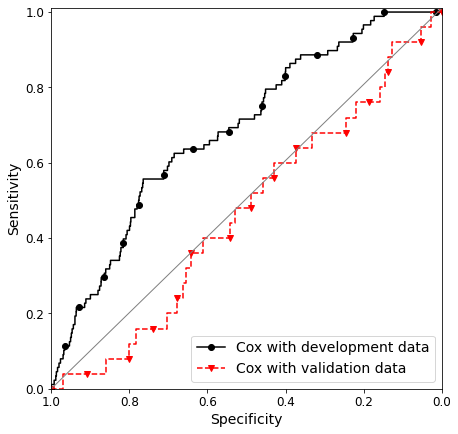

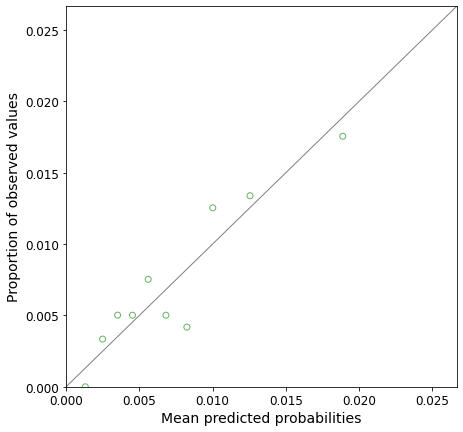

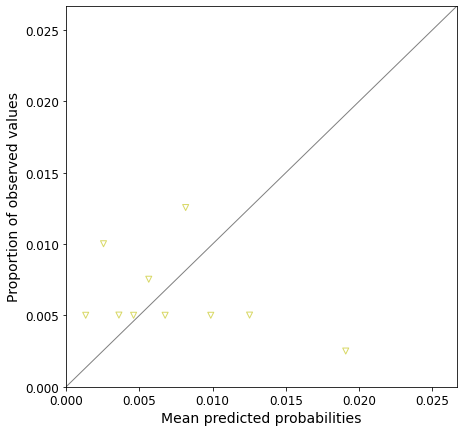

In [55]:
#data prep
data, data_cough_no_abs_prevl_enc = cox_data_prep(data_cough_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'no_abs_prevl', data_cough_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'no_abs_prevl', data_cough_no_abs_prevl)

try:
    #build cox model 
    cph_cough_no_abs_prevl, data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test = cox_model_build('cough', 'no_abs_prevl', data_cough_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_no_abs_prevl, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_no_abs_prevl.csv', data_cough_no_abs_prevl_enc, data_cough_no_abs_prevl, 'sum_betas_cph_cough_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_no_abs_prevl, 'event_cough_admitted', data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_no_abs_prevl, data_cough_no_abs_prevl_train, 'event_cough_admitted', data_cough_no_abs_prevl_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_no_abs_prevl_train.jpg', 'calibration_cph_cough_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_no_abs_prevl, 'cough', 'no_abs_prevl', data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent cough with antibiotics

<lifelines.CoxPHFitter: fitted with 1305 total observations, 1296 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1305
number of events observed = 9
   partial log-likelihood = -44.40
         time fit was run = 2022-11-22 17:11:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.84       2.31       1.37            -1.86             3.53                 0.16                34.07
CCI_cat[T.medium]                0.98       2.68       1.35            -1.65             3.62                 0.19                37.49
CCI_cat[T.high]                  0.99       2.68       1.59            -2.12             4.09                 0.12                59.99
CCI_cat[T.very_high]             0.30       1.34       1.58            -2.80             3.40                 0.06                29.82
age_cat[T.25_34]               -17.88       0.00    9039.72        -17735.40         17699.64                 0.00                  inf
age_cat[T.35_44]                 0.80       2.23       1.58            -2.30             3.91                 0.10                49.84
age_cat[T.45_54]                 1.76       5.82       1.37            -0.93             4.45                 0.40                85.74
age_cat[T.55_64]                 0.85       2.34       1.38            -1.85             3.55                 0.16                34.66
age_cat[T.65_74]                 1.01       2.76       1.39            -1.71             3.74                 0.18                41.90
age_cat[T.75_more]             -17.84       0.00    8643.68        -16959.15         16923.47                 0.00                  inf
antibacterial_brit              -0.14       0.87       0.31            -0.75             0.46                 0.47                 1.59
bmi_cat[T.obese]                19.30   2.42e+08    8892.28        -17409.24         17447.85                 0.00                  inf
bmi_cat[T.overweight]            0.43       1.53   12272.61        -24053.45         24054.30                 0.00                  inf
bmi_cat[T.underweight]          -0.48       0.62   16851.66        -33029.12         33028.17                 0.00                  inf
bmi_cat[T.unknown]              18.70   1.32e+08    8892.28        -17409.85         17447.25                 0.00                  inf
ethnicity[T.unknown]            -0.09       0.91       1.53            -3.10             2.91                 0.05                18.40
ethnicity[T.white]               1.05       2.85       1.24            -1.39             3.49                 0.25                32.68
flu_vaccine[T.yes]             -17.87       0.00    8802.99        -17271.42         17235.68                 0.00                  inf
imd[T.medium]                   -0.29       0.75       1.51            -3.26             2.68                 0.04                14.58
imd[T.unaffluent]                0.94       2.57       1.29            -1.59             3.47                 0.20                32.20
imd[T.unknown]                 -17.80       0.00   14137.46        -27726.72         27691.11                 0.00                  inf
imd[T.very_affluent]            -0.66       0.52       1.58            -3.75             2.44                 0.02                11.43
imd[T.very_unaffluent]           1.80       6.07       1.19            -0.54             4.14                 0.58                63.07
region[T.east_midlands]        -18.83       0.00    8330.17        -16345.67         16308.01                 0.00                  inf
region[T.london]                -0.82       0.44       1.51            -3

12906


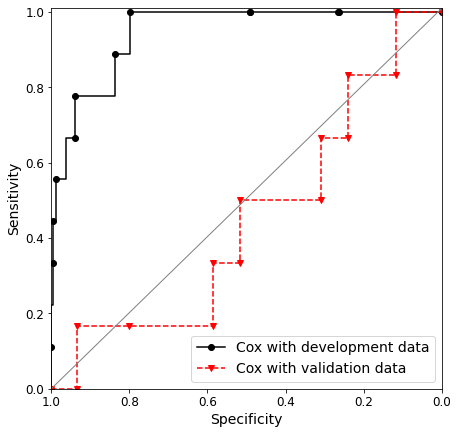

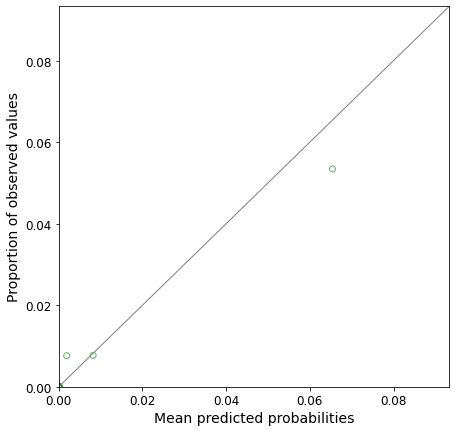

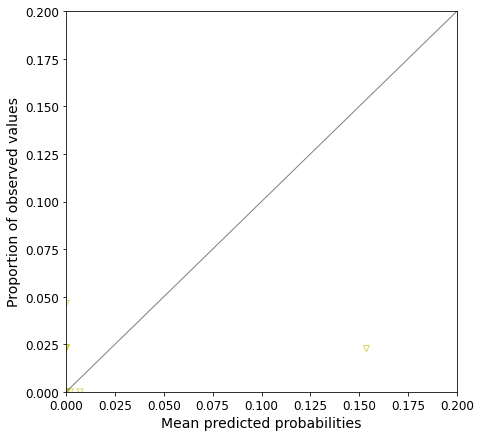

In [56]:
#data prep
data, data_cough_abs_prevl_enc = cox_data_prep(data_cough_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'abs_prevl', data_cough_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'abs_prevl', data_cough_abs_prevl)

try:
    #build cox model 
    cph_cough_abs_prevl, data_cough_abs_prevl_train, data_cough_abs_prevl_test = cox_model_build('cough', 'abs_prevl', data_cough_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_abs_prevl, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_abs_prevl.csv', data_cough_abs_prevl_enc, data_cough_abs_prevl, 'sum_betas_cph_cough_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_abs_prevl, 'event_cough_admitted', data_cough_abs_prevl_train, data_cough_abs_prevl_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_abs_prevl, data_cough_abs_prevl_train, 'event_cough_admitted', data_cough_abs_prevl_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_abs_prevl_train.jpg', 'calibration_cph_cough_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_abs_prevl, 'cough', 'abs_prevl', data_cough_abs_prevl_train, data_cough_abs_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident cough

In [57]:
#data prep
data, data_cough_incdt_enc = cox_data_prep(data_cough_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary tables from preped data
make_summary_table('cough', 'incdt', data_cough_incdt_enc)
make_summary_table_hosped('cough', 'incdt', data_cough_incdt)

try:
    cph_cough_incdt, data_cough_incdt_train, data_cough_incdt_test = cox_model_abs_build('cough', 'incdt', data_cough_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_incdt, 'cough', 'incdt', data_cough_incdt_train, data_cough_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119280 total observations, 118403 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 119280
number of events observed = 877
   partial log-likelihood = -10222.79
         time fit was run = 2022-11-22 17:12:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.99       0.10            -0.21             0.18                 0.81                 1.19
CCI_cat[T.medium]               -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
CCI_cat[T.high]                 -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.29
CCI_cat[T.very_high]             0.14       1.15       0.11            -0.08             0.36                 0.92                 1.43
age_cat[T.25_34]                 0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
age_cat[T.35_44]                 0.05       1.05       0.13            -0.20             0.30                 0.82                 1.35
age_cat[T.45_54]                -0.18       0.83       0.13            -0.45             0.08                 0.64                 1.08
age_cat[T.55_64]                 0.20       1.22       0.12            -0.05             0.44                 0.96                 1.55
age_cat[T.65_74]                -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.75_more]               0.17       1.18       0.12            -0.08             0.41                 0.93                 1.51
antibacterial_brit               0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
bmi_cat[T.obese]                -0.06       0.94       0.12            -0.30             0.19                 0.74                 1.20
bmi_cat[T.overweight]            0.03       1.03       0.15            -0.26             0.33                 0.77                 1.39
bmi_cat[T.underweight]          -0.18       0.84       0.23            -0.63             0.28                 0.53                 1.32
bmi_cat[T.unknown]              -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
cough_ab_date                   -0.39       0.68       0.13            -0.65            -0.13                 0.52                 0.88
ethnicity[T.unknown]             0.06       1.06       0.11            -0.16             0.28                 0.86                 1.32
ethnicity[T.white]               0.01       1.01       0.10            -0.18             0.20                 0.83                 1.22
flu_vaccine[T.yes]              -0.07       0.94       0.12            -0.29             0.16                 0.75                 1.17
imd[T.medium]                   -0.08       0.93       0.11            -0.30             0.14                 0.74                 1.15
imd[T.unaffluent]                0.03       1.03       0.11            -0.18             0.25                 0.83                 1.28
imd[T.unknown]                  -0.09       0.92       0.17            -0.43             0.25                 0.65                 1.29
imd[T.very_affluent]             0.12       1.12       0.11            -0.09             0.33                 0.91                 1.39
imd[T.very_unaffluent]          -0.02       0.98       0.11            -0.24             0.19                 0.79                 1.21
region[T.east_midlands]          0.13       1.14       0.15   

13055


### 5-6- hospital admission related to prevalent cough

In [58]:
#data prep
data, data_cough_prevl_enc = cox_data_prep(data_cough_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary tables from preped data
make_summary_table('cough', 'prevl', data_cough_prevl_enc)
make_summary_table_hosped('cough', 'prevl', data_cough_prevl)

try:
    cph_cough_prevl, data_cough_prevl_train, data_cough_prevl_test = cox_model_abs_build('cough', 'prevl', data_cough_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl, 'cough', 'prevl', data_cough_prevl_train, data_cough_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13261 total observations, 13171 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 13261
number of events observed = 90
   partial log-likelihood = -832.12
         time fit was run = 2022-11-22 17:12:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.31            -0.69             0.50                 0.50                 1.66
CCI_cat[T.medium]               -0.17       0.84       0.35            -0.85             0.51                 0.43                 1.67
CCI_cat[T.high]                  0.13       1.14       0.39            -0.63             0.89                 0.53                 2.44
CCI_cat[T.very_high]             0.17       1.18       0.34            -0.51             0.84                 0.60                 2.32
age_cat[T.25_34]                -0.05       0.96       0.42            -0.87             0.77                 0.42                 2.17
age_cat[T.35_44]                 0.04       1.04       0.40            -0.75             0.82                 0.47                 2.28
age_cat[T.45_54]                 0.15       1.16       0.39            -0.61             0.91                 0.54                 2.49
age_cat[T.55_64]                 0.31       1.37       0.37            -0.42             1.04                 0.66                 2.84
age_cat[T.65_74]                -0.12       0.89       0.42            -0.94             0.70                 0.39                 2.02
age_cat[T.75_more]              -0.19       0.83       0.43            -1.03             0.65                 0.36                 1.92
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 1.10       3.01       0.59            -0.06             2.27                 0.94                 9.63
bmi_cat[T.overweight]            0.87       2.40       0.66            -0.42             2.17                 0.66                 8.72
bmi_cat[T.underweight]           0.45       1.57       0.91            -1.34             2.24                 0.26                 9.40
bmi_cat[T.unknown]               0.74       2.10       0.62            -0.48             1.96                 0.62                 7.11
cough_ab_date                    0.23       1.26       0.32            -0.40             0.86                 0.67                 2.36
ethnicity[T.unknown]            -0.12       0.88       0.39            -0.89             0.64                 0.41                 1.90
ethnicity[T.white]               0.38       1.47       0.33            -0.26             1.03                 0.77                 2.79
flu_vaccine[T.yes]               0.61       1.84       0.28             0.05             1.17                 1.05                 3.21
imd[T.medium]                   -0.14       0.87       0.34            -0.81             0.52                 0.44                 1.69
imd[T.unaffluent]                0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
imd[T.unknown]                  -0.60       0.55       0.62            -1.82             0.62                 0.16                 1.86
imd[T.very_affluent]             0.10       1.11       0.32            -0.53             0.73                 0.59                 2.08
imd[T.very_unaffluent]          -0.47       0.63       0.37            -1.19             0.26                 0.30                 1.29
region[T.east_midlands]          0.06       1.06       0.58         

13019


### 5-7- hospital admission related to incident cough with prescribed antibiotics categories

In [59]:
#data prep
data, data_cough_incdt_abs_enc = cox_data_prep(data_cough_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_abs, data_cough_incdt_abs_train, data_cough_incdt_abs_test = cox_model_ab_type_build('cough', 'incdt_ab_type', data_cough_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_abs, 'cough', 'incdt_abs', data_cough_incdt_abs_train, data_cough_incdt_abs_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119280 total observations, 118403 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 119280
number of events observed = 877
   partial log-likelihood = -10222.40
         time fit was run = 2022-11-22 17:12:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.10            -0.21             0.18                 0.81                 1.19
CCI_cat[T.medium]               -0.03       0.97       0.11            -0.25             0.18                 0.78                 1.20
CCI_cat[T.high]                 -0.01       0.99       0.13            -0.27             0.25                 0.76                 1.29
CCI_cat[T.very_high]             0.14       1.15       0.11            -0.08             0.35                 0.92                 1.43
ab_type_cat[T.Doxycycline]       0.04       1.04       0.84            -1.60             1.68                 0.20                 5.35
ab_type_cat[T.no]                0.06       1.06       0.45            -0.82             0.94                 0.44                 2.56
ab_type_cat[T.other]            -0.36       0.70       0.47            -1.28             0.55                 0.28                 1.74
age_cat[T.25_34]                 0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
age_cat[T.35_44]                 0.05       1.05       0.13            -0.20             0.30                 0.82                 1.35
age_cat[T.45_54]                -0.18       0.83       0.13            -0.45             0.08                 0.64                 1.08
age_cat[T.55_64]                 0.20       1.22       0.12            -0.05             0.44                 0.96                 1.55
age_cat[T.65_74]                -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
age_cat[T.75_more]               0.17       1.18       0.12            -0.08             0.41                 0.93                 1.51
antibacterial_brit               0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
bmi_cat[T.obese]                -0.06       0.94       0.12            -0.30             0.19                 0.74                 1.20
bmi_cat[T.overweight]            0.03       1.03       0.15            -0.26             0.33                 0.77                 1.39
bmi_cat[T.underweight]          -0.18       0.84       0.23            -0.63             0.28                 0.53                 1.32
bmi_cat[T.unknown]              -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
ethnicity[T.unknown]             0.06       1.06       0.11            -0.16             0.28                 0.86                 1.32
ethnicity[T.white]               0.01       1.01       0.10            -0.18             0.20                 0.83                 1.22
flu_vaccine[T.yes]              -0.07       0.94       0.12            -0.29             0.16                 0.75                 1.17
imd[T.medium]                   -0.08       0.93       0.11            -0.30             0.14                 0.74                 1.15
imd[T.unaffluent]                0.03       1.03       0.11            -0.18             0.25                 0.83                 1.28
imd[T.unknown]                  -0.09       0.92       0.17            -0.43             0.25                 0.65                 1.29
imd[T.very_affluent]             0.12       1.13       0.11   

13611


### 5-8- hospital admission related to prevalent cough with prescribed antibiotics categories

In [60]:
#data prep
data, data_cough_prevl_abs_enc = cox_data_prep(data_cough_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_abs, data_cough_prevl_abs_train, data_cough_prevl_abs_test = cox_model_ab_type_build('cough', 'prevl_ab_type', data_cough_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_abs, 'cough', 'prevl_abs', data_cough_prevl_abs_train, data_cough_prevl_abs_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13261 total observations, 13171 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 13261
number of events observed = 90
   partial log-likelihood = -831.33
         time fit was run = 2022-11-22 17:12:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.31            -0.70             0.50                 0.50                 1.65
CCI_cat[T.medium]               -0.18       0.84       0.35            -0.86             0.51                 0.42                 1.66
CCI_cat[T.high]                  0.12       1.13       0.39            -0.64             0.88                 0.53                 2.41
CCI_cat[T.very_high]             0.16       1.17       0.34            -0.51             0.83                 0.60                 2.30
ab_type_cat[T.Doxycycline]      -0.34       0.71    4733.14         -9277.12          9276.43                 0.00                  inf
ab_type_cat[T.no]               14.71   2.45e+06    2487.17         -4860.05          4889.47                 0.00                  inf
ab_type_cat[T.other]            15.01   3.30e+06    2487.17         -4859.75          4889.77                 0.00                  inf
age_cat[T.25_34]                -0.04       0.96       0.42            -0.86             0.78                 0.42                 2.18
age_cat[T.35_44]                 0.03       1.03       0.40            -0.75             0.82                 0.47                 2.27
age_cat[T.45_54]                 0.15       1.16       0.39            -0.61             0.91                 0.54                 2.49
age_cat[T.55_64]                 0.31       1.36       0.37            -0.42             1.04                 0.65                 2.83
age_cat[T.65_74]                -0.12       0.88       0.42            -0.94             0.70                 0.39                 2.01
age_cat[T.75_more]              -0.18       0.83       0.43            -1.02             0.66                 0.36                 1.93
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 1.10       3.02       0.59            -0.06             2.27                 0.94                 9.65
bmi_cat[T.overweight]            0.88       2.41       0.66            -0.41             2.17                 0.66                 8.76
bmi_cat[T.underweight]           0.46       1.58       0.91            -1.33             2.25                 0.26                 9.46
bmi_cat[T.unknown]               0.74       2.11       0.62            -0.47             1.96                 0.62                 7.12
ethnicity[T.unknown]            -0.12       0.89       0.39            -0.89             0.65                 0.41                 1.92
ethnicity[T.white]               0.39       1.47       0.33            -0.25             1.03                 0.78                 2.80
flu_vaccine[T.yes]               0.62       1.86       0.28             0.06             1.18                 1.07                 3.24
imd[T.medium]                   -0.14       0.87       0.34            -0.81             0.52                 0.45                 1.69
imd[T.unaffluent]                0.05       1.05       0.32            -0.58             0.68                 0.56                 1.98
imd[T.unknown]                  -0.60       0.55       0.62            -1.82             0.62                 0.16                 1.86
imd[T.very_affluent]             0.10       1.11       0.32         

13617


### 5-9- stratified by sex
#### 5-9-1- incident males

In [61]:
#data prep
data, data_cough_incdt_males_enc = cox_data_prep(data_cough_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_males, data_cough_incdt_males_train, data_cough_incdt_males_test = cox_model_strat_sex_build('cough', 'incdt_males', data_cough_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_males, 'cough', 'incdt_males', data_cough_incdt_males_train, data_cough_incdt_males_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58591 total observations, 58152 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 58591
number of events observed = 439
   partial log-likelihood = -4799.08
         time fit was run = 2022-11-22 17:12:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.14            -0.20             0.37                 0.82                 1.44
CCI_cat[T.medium]                0.19       1.20       0.16            -0.12             0.49                 0.89                 1.63
CCI_cat[T.high]                 -0.02       0.98       0.20            -0.41             0.36                 0.66                 1.44
CCI_cat[T.very_high]             0.22       1.24       0.16            -0.10             0.54                 0.90                 1.71
age_cat[T.25_34]                 0.07       1.07       0.18            -0.29             0.43                 0.75                 1.53
age_cat[T.35_44]                -0.14       0.87       0.19            -0.51             0.24                 0.60                 1.27
age_cat[T.45_54]                -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.37
age_cat[T.55_64]                 0.30       1.35       0.17            -0.04             0.64                 0.96                 1.90
age_cat[T.65_74]                 0.11       1.12       0.18            -0.24             0.47                 0.79                 1.60
age_cat[T.75_more]               0.16       1.18       0.18            -0.19             0.51                 0.83                 1.67
antibacterial_brit               0.06       1.06       0.03            -0.01             0.12                 0.99                 1.13
bmi_cat[T.obese]                -0.25       0.78       0.16            -0.56             0.07                 0.57                 1.07
bmi_cat[T.overweight]           -0.36       0.70       0.21            -0.77             0.05                 0.46                 1.05
bmi_cat[T.underweight]          -0.43       0.65       0.32            -1.07             0.21                 0.34                 1.23
bmi_cat[T.unknown]              -0.35       0.71       0.18            -0.69            -0.00                 0.50                 1.00
cough_ab_date                   -0.25       0.78       0.18            -0.59             0.10                 0.55                 1.10
ethnicity[T.unknown]             0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
ethnicity[T.white]              -0.06       0.94       0.14            -0.33             0.20                 0.72                 1.23
flu_vaccine[T.yes]              -0.06       0.94       0.16            -0.38             0.25                 0.69                 1.29
imd[T.medium]                   -0.02       0.98       0.16            -0.33             0.30                 0.72                 1.34
imd[T.unaffluent]               -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
imd[T.unknown]                   0.04       1.04       0.24            -0.42             0.51                 0.66                 1.66
imd[T.very_affluent]             0.16       1.17       0.15            -0.14             0.46                 0.87                 1.58
imd[T.very_unaffluent]           0.11       1.11       0.15            -0.19             0.41                 0.82                 1.51
region[T.east_midlands]          0.04       1.04       0.20       

12777


#### 5-9-2- incident females

In [62]:
#data prep
data, data_cough_incdt_females_enc = cox_data_prep(data_cough_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_females, data_cough_incdt_females_train, data_cough_incdt_females_test = cox_model_strat_sex_build('cough', 'incdt_females', data_cough_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_females, 'cough', 'incdt_females', data_cough_incdt_females_train, data_cough_incdt_females_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60689 total observations, 60254 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 60689
number of events observed = 435
   partial log-likelihood = -4760.93
         time fit was run = 2022-11-22 17:12:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.14            -0.50             0.03                 0.61                 1.03
CCI_cat[T.medium]               -0.14       0.87       0.15            -0.44             0.15                 0.64                 1.17
CCI_cat[T.high]                 -0.09       0.92       0.18            -0.44             0.27                 0.64                 1.31
CCI_cat[T.very_high]            -0.01       0.99       0.15            -0.31             0.29                 0.73                 1.34
age_cat[T.25_34]                 0.28       1.32       0.19            -0.09             0.65                 0.91                 1.91
age_cat[T.35_44]                 0.33       1.38       0.19            -0.04             0.69                 0.96                 1.99
age_cat[T.45_54]                -0.06       0.95       0.20            -0.45             0.34                 0.64                 1.41
age_cat[T.55_64]                 0.43       1.54       0.18             0.07             0.79                 1.08                 2.21
age_cat[T.65_74]                 0.25       1.28       0.19            -0.12             0.62                 0.88                 1.87
age_cat[T.75_more]               0.34       1.40       0.19            -0.02             0.70                 0.98                 2.02
antibacterial_brit              -0.01       0.99       0.03            -0.08             0.05                 0.93                 1.06
bmi_cat[T.obese]                -0.10       0.91       0.18            -0.46             0.26                 0.63                 1.30
bmi_cat[T.overweight]            0.18       1.20       0.21            -0.24             0.60                 0.79                 1.82
bmi_cat[T.underweight]          -0.10       0.91       0.32            -0.73             0.54                 0.48                 1.72
bmi_cat[T.unknown]               0.14       1.15       0.19            -0.23             0.51                 0.79                 1.67
cough_ab_date                   -0.28       0.76       0.18            -0.63             0.07                 0.53                 1.07
ethnicity[T.unknown]             0.01       1.01       0.16            -0.30             0.31                 0.74                 1.37
ethnicity[T.white]               0.03       1.03       0.14            -0.24             0.30                 0.79                 1.35
flu_vaccine[T.yes]              -0.16       0.86       0.17            -0.49             0.18                 0.61                 1.19
imd[T.medium]                   -0.13       0.88       0.15            -0.43             0.16                 0.65                 1.18
imd[T.unaffluent]               -0.23       0.79       0.16            -0.54             0.07                 0.58                 1.07
imd[T.unknown]                  -0.44       0.65       0.27            -0.97             0.09                 0.38                 1.10
imd[T.very_affluent]             0.01       1.01       0.15            -0.27             0.30                 0.76                 1.34
imd[T.very_unaffluent]          -0.25       0.78       0.16            -0.56             0.05                 0.57                 1.05
region[T.east_midlands]          0.45       1.58       0.24       

12765


#### 5-9-3- prevalent males

In [63]:
#data prep
data, data_cough_prevl_males_enc = cox_data_prep(data_cough_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_males, data_cough_prevl_males_train, data_cough_prevl_males_test = cox_model_strat_sex_build('cough', 'prevl_males', data_cough_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_cough_prevl_males, 'cough', 'prevl_males', data_cough_prevl_males_train, data_cough_prevl_males_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6447 total observations, 6385 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 6447
number of events observed = 62
   partial log-likelihood = -521.15
         time fit was run = 2022-11-22 17:12:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.37            -0.89             0.58                 0.41                 1.78
CCI_cat[T.medium]               -0.13       0.87       0.42            -0.96             0.69                 0.38                 1.99
CCI_cat[T.high]                  0.07       1.07       0.48            -0.87             1.00                 0.42                 2.72
CCI_cat[T.very_high]             0.40       1.49       0.39            -0.37             1.17                 0.69                 3.23
age_cat[T.25_34]                 0.51       1.67       0.52            -0.50             1.53                 0.61                 4.62
age_cat[T.35_44]                 0.62       1.86       0.51            -0.38             1.62                 0.69                 5.05
age_cat[T.45_54]                 0.31       1.36       0.53            -0.73             1.34                 0.48                 3.83
age_cat[T.55_64]                 0.47       1.60       0.52            -0.54             1.48                 0.58                 4.41
age_cat[T.65_74]                 0.37       1.44       0.53            -0.67             1.40                 0.51                 4.07
age_cat[T.75_more]               0.11       1.12       0.56            -0.98             1.21                 0.38                 3.34
antibacterial_brit               0.01       1.01       0.09            -0.17             0.19                 0.85                 1.20
bmi_cat[T.obese]                 0.68       1.98       0.60            -0.50             1.86                 0.61                 6.45
bmi_cat[T.overweight]            0.53       1.71       0.69            -0.82             1.89                 0.44                 6.62
bmi_cat[T.underweight]           0.50       1.65       0.92            -1.29             2.30                 0.27                 9.96
bmi_cat[T.unknown]               0.58       1.79       0.63            -0.66             1.83                 0.52                 6.21
cough_ab_date                    0.20       1.22       0.40            -0.59             0.99                 0.55                 2.69
ethnicity[T.unknown]            -0.23       0.79       0.51            -1.22             0.76                 0.29                 2.14
ethnicity[T.white]               0.51       1.66       0.41            -0.29             1.31                 0.75                 3.69
flu_vaccine[T.yes]               0.23       1.25       0.38            -0.52             0.97                 0.60                 2.64
imd[T.medium]                    0.25       1.28       0.40            -0.55             1.04                 0.58                 2.82
imd[T.unaffluent]               -0.40       0.67       0.48            -1.35             0.55                 0.26                 1.73
imd[T.unknown]                  -1.09       0.33       1.05            -3.14             0.95                 0.04                 2.60
imd[T.very_affluent]             0.63       1.88       0.38            -0.12             1.39                 0.89                 4.00
imd[T.very_unaffluent]          -0.03       0.97       0.43            -0.86             0.81                 0.42                 2.25
region[T.east_midlands]         -0.28       0.75       0.77            

12785


#### 5-9-4- prevalent females

In [64]:
try:
    #data prep
    data, data_cough_prevl_females_enc = cox_data_prep(data_cough_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

    #cox model
    cph_cough_prevl_females, data_cough_prevl_females_train, data_cough_prevl_females_test = cox_model_strat_sex_build('cough', 'prevl_females', data_cough_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_females, 'cough', 'prevl_females', data_cough_prevl_females_train, data_cough_prevl_females_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6814 total observations, 6768 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 6814
number of events observed = 46
   partial log-likelihood = -393.66
         time fit was run = 2022-11-22 17:12:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.46            -0.81             1.01                 0.44                 2.75
CCI_cat[T.medium]                0.33       1.39       0.49            -0.64             1.30                 0.53                 3.66
CCI_cat[T.high]                  0.69       1.99       0.52            -0.33             1.71                 0.72                 5.52
CCI_cat[T.very_high]             0.21       1.24       0.54            -0.84             1.27                 0.43                 3.55
age_cat[T.25_34]                -0.50       0.61       0.57            -1.62             0.62                 0.20                 1.86
age_cat[T.35_44]                -0.18       0.83       0.50            -1.17             0.80                 0.31                 2.24
age_cat[T.45_54]                -0.54       0.58       0.57            -1.66             0.58                 0.19                 1.79
age_cat[T.55_64]                -0.09       0.92       0.50            -1.07             0.90                 0.34                 2.45
age_cat[T.65_74]                -0.05       0.95       0.50            -1.04             0.93                 0.35                 2.54
age_cat[T.75_more]              -0.78       0.46       0.61            -1.98             0.43                 0.14                 1.53
antibacterial_brit               0.08       1.09       0.10            -0.11             0.28                 0.89                 1.32
bmi_cat[T.obese]                 0.75       2.12       0.74            -0.69             2.19                 0.50                 8.95
bmi_cat[T.overweight]            0.61       1.83       0.84            -1.04             2.25                 0.35                 9.49
bmi_cat[T.underweight]           0.18       1.19       1.23            -2.23             2.58                 0.11                13.23
bmi_cat[T.unknown]               0.74       2.11       0.77            -0.76             2.25                 0.47                 9.45
cough_ab_date                   -0.14       0.87       0.53            -1.17             0.89                 0.31                 2.44
ethnicity[T.unknown]            -0.05       0.95       0.49            -1.00             0.90                 0.37                 2.47
ethnicity[T.white]               0.05       1.05       0.42            -0.79             0.88                 0.46                 2.41
flu_vaccine[T.yes]               0.36       1.43       0.44            -0.51             1.22                 0.60                 3.39
imd[T.medium]                   -0.07       0.93       0.45            -0.95             0.81                 0.39                 2.25
imd[T.unaffluent]                0.02       1.02       0.44            -0.84             0.88                 0.43                 2.42
imd[T.unknown]                   0.05       1.05       0.66            -1.25             1.34                 0.29                 3.83
imd[T.very_affluent]            -0.98       0.37       0.59            -2.14             0.18                 0.12                 1.20
imd[T.very_unaffluent]          -0.24       0.78       0.48            -1.18             0.69                 0.31                 1.99
region[T.east_midlands]          0.54       1.71       0.92            

12768


### 5-10- stratified by age category
#### 5-10-1- incident

In [65]:
#data prep
data, data_cough_incdt_15_24_enc = cox_data_prep(data_cough_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_15_24, data_cough_incdt_15_24_train, data_cough_incdt_15_24_test = cox_model_strat_age_build('cough', 'incdt_15_24', data_cough_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_15_24, 'cough', 'incdt_15_24', data_cough_incdt_15_24_train, data_cough_incdt_15_24_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17124 total observations, 17013 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17124
number of events observed = 111
   partial log-likelihood = -1068.36
         time fit was run = 2022-11-22 17:13:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.26            -0.55             0.47                 0.58                 1.59
CCI_cat[T.medium]               -0.19       0.83       0.31            -0.79             0.41                 0.45                 1.51
CCI_cat[T.high]                 -0.22       0.80       0.38            -0.96             0.53                 0.38                 1.69
CCI_cat[T.very_high]            -0.31       0.74       0.33            -0.96             0.35                 0.38                 1.41
antibacterial_brit              -0.03       0.97       0.07            -0.16             0.11                 0.85                 1.11
bmi_cat[T.obese]                -0.40       0.67       0.32            -1.03             0.23                 0.36                 1.26
bmi_cat[T.overweight]           -0.13       0.88       0.39            -0.89             0.63                 0.41                 1.89
bmi_cat[T.underweight]          -0.92       0.40       0.76            -2.42             0.58                 0.09                 1.79
bmi_cat[T.unknown]              -0.35       0.70       0.35            -1.03             0.32                 0.36                 1.38
cough_ab_date                   -0.64       0.53       0.42            -1.47             0.18                 0.23                 1.20
ethnicity[T.unknown]            -0.03       0.97       0.33            -0.67             0.62                 0.51                 1.86
ethnicity[T.white]               0.17       1.19       0.28            -0.38             0.73                 0.68                 2.07
flu_vaccine[T.yes]              -0.10       0.91       0.33            -0.75             0.55                 0.47                 1.74
imd[T.medium]                    0.32       1.38       0.32            -0.31             0.96                 0.73                 2.60
imd[T.unaffluent]                0.04       1.04       0.35            -0.64             0.73                 0.53                 2.07
imd[T.unknown]                  -0.43       0.65       0.63            -1.66             0.81                 0.19                 2.24
imd[T.very_affluent]             0.50       1.64       0.31            -0.12             1.11                 0.89                 3.04
imd[T.very_unaffluent]           0.36       1.44       0.33            -0.27             1.00                 0.76                 2.73
region[T.east_midlands]          0.15       1.16       0.39            -0.63             0.92                 0.53                 2.51
region[T.london]                -0.15       0.86       0.36            -0.86             0.56                 0.42                 1.75
region[T.north_east]            -0.31       0.73       0.44            -1.18             0.55                 0.31                 1.74
region[T.north_west]             0.12       1.12       0.39            -0.66             0.89                 0.52                 2.43
region[T.south_east]            -0.43       0.65       0.46            -1.32             0.47                 0.27                 1.60
region[T.south_west]             0.01       1.01       0.41            -0.79             0.82                 0.45                 2.26
region[T.west_midlands]         -0.03       0.97       0.42       

11417


In [66]:
#data prep
data, data_cough_incdt_25_34_enc = cox_data_prep(data_cough_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_25_34, data_cough_incdt_25_34_train, data_cough_incdt_25_34_test = cox_model_strat_age_build('cough', 'incdt_25_34', data_cough_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_25_34, 'cough', 'incdt_25_34', data_cough_incdt_25_34_train, data_cough_incdt_25_34_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16729 total observations, 16615 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 16729
number of events observed = 114
   partial log-likelihood = -1089.51
         time fit was run = 2022-11-22 17:13:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.59       1.80       0.31            -0.01             1.18                 0.99                 3.27
CCI_cat[T.medium]                0.63       1.87       0.33            -0.01             1.27                 0.99                 3.56
CCI_cat[T.high]                 -0.21       0.81       0.49            -1.16             0.75                 0.31                 2.12
CCI_cat[T.very_high]             0.55       1.73       0.35            -0.14             1.23                 0.87                 3.43
antibacterial_brit              -0.06       0.94       0.07            -0.20             0.07                 0.82                 1.07
bmi_cat[T.obese]                -0.37       0.69       0.32            -1.00             0.26                 0.37                 1.30
bmi_cat[T.overweight]            0.06       1.06       0.37            -0.66             0.79                 0.52                 2.20
bmi_cat[T.underweight]          -0.31       0.73       0.58            -1.45             0.82                 0.24                 2.27
bmi_cat[T.unknown]              -0.35       0.71       0.35            -1.03             0.33                 0.36                 1.40
cough_ab_date                    0.12       1.13       0.30            -0.46             0.70                 0.63                 2.02
ethnicity[T.unknown]            -0.01       0.99       0.30            -0.59             0.58                 0.55                 1.79
ethnicity[T.white]              -0.10       0.91       0.27            -0.62             0.42                 0.54                 1.53
flu_vaccine[T.yes]               0.11       1.12       0.31            -0.49             0.71                 0.61                 2.03
imd[T.medium]                    0.00       1.00       0.29            -0.56             0.57                 0.57                 1.77
imd[T.unaffluent]               -0.16       0.85       0.31            -0.78             0.45                 0.46                 1.56
imd[T.unknown]                   0.39       1.48       0.39            -0.38             1.16                 0.69                 3.18
imd[T.very_affluent]            -0.18       0.84       0.30            -0.77             0.42                 0.46                 1.52
imd[T.very_unaffluent]          -0.15       0.86       0.31            -0.75             0.46                 0.47                 1.58
region[T.east_midlands]         -0.23       0.80       0.56            -1.32             0.86                 0.27                 2.37
region[T.london]                 0.30       1.35       0.44            -0.56             1.16                 0.57                 3.20
region[T.north_east]             0.89       2.45       0.44             0.03             1.76                 1.03                 5.82
region[T.north_west]             0.37       1.45       0.48            -0.58             1.32                 0.56                 3.74
region[T.south_east]             0.82       2.27       0.45            -0.07             1.71                 0.93                 5.51
region[T.south_west]             0.29       1.34       0.49            -0.67             1.26                 0.51                 3.52
region[T.west_midlands]          0.09       1.10       0.52       

11404


In [67]:
#data prep
data, data_cough_incdt_35_44_enc = cox_data_prep(data_cough_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_35_44, data_cough_incdt_35_44_train, data_cough_incdt_35_44_test = cox_model_strat_age_build('cough', 'incdt_35_44', data_cough_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_35_44, 'cough', 'incdt_35_44', data_cough_incdt_35_44_train, data_cough_incdt_35_44_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17346 total observations, 17218 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17346
number of events observed = 128
   partial log-likelihood = -1229.39
         time fit was run = 2022-11-22 17:13:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.18       0.26            -0.35             0.68                 0.70                 1.98
CCI_cat[T.medium]                0.06       1.06       0.30            -0.53             0.64                 0.59                 1.89
CCI_cat[T.high]                  0.12       1.12       0.35            -0.58             0.81                 0.56                 2.24
CCI_cat[T.very_high]             0.24       1.27       0.30            -0.35             0.83                 0.70                 2.30
antibacterial_brit               0.06       1.06       0.06            -0.06             0.18                 0.94                 1.19
bmi_cat[T.obese]                -0.34       0.71       0.31            -0.94             0.27                 0.39                 1.31
bmi_cat[T.overweight]           -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.90
bmi_cat[T.underweight]          -0.45       0.64       0.64            -1.71             0.81                 0.18                 2.25
bmi_cat[T.unknown]              -0.07       0.94       0.32            -0.70             0.57                 0.50                 1.76
cough_ab_date                   -1.57       0.21       0.58            -2.72            -0.43                 0.07                 0.65
ethnicity[T.unknown]            -0.06       0.95       0.27            -0.58             0.47                 0.56                 1.60
ethnicity[T.white]              -0.25       0.78       0.24            -0.73             0.22                 0.48                 1.24
flu_vaccine[T.yes]              -0.21       0.81       0.33            -0.86             0.43                 0.42                 1.54
imd[T.medium]                   -0.02       0.98       0.30            -0.60             0.57                 0.55                 1.77
imd[T.unaffluent]                0.04       1.04       0.29            -0.53             0.60                 0.59                 1.83
imd[T.unknown]                   0.18       1.19       0.41            -0.63             0.98                 0.53                 2.68
imd[T.very_affluent]             0.04       1.04       0.29            -0.53             0.61                 0.59                 1.84
imd[T.very_unaffluent]           0.14       1.15       0.29            -0.43             0.70                 0.65                 2.01
region[T.east_midlands]         -0.14       0.87       0.38            -0.89             0.60                 0.41                 1.83
region[T.london]                -0.16       0.86       0.32            -0.79             0.48                 0.45                 1.61
region[T.north_east]            -0.44       0.64       0.41            -1.24             0.36                 0.29                 1.43
region[T.north_west]             0.03       1.03       0.35            -0.67             0.73                 0.51                 2.06
region[T.south_east]            -0.51       0.60       0.42            -1.33             0.32                 0.26                 1.38
region[T.south_west]             0.14       1.15       0.35            -0.55             0.83                 0.58                 2.28
region[T.west_midlands]         -0.80       0.45       0.46       

11401


In [68]:
#data prep
data, data_cough_incdt_45_54_enc = cox_data_prep(data_cough_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_45_54, data_cough_incdt_45_54_train, data_cough_incdt_45_54_test = cox_model_strat_age_build('cough', 'incdt_45_54', data_cough_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_45_54, 'cough', 'incdt_45_54', data_cough_incdt_45_54_train, data_cough_incdt_45_54_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17235 total observations, 17135 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17235
number of events observed = 100
   partial log-likelihood = -961.45
         time fit was run = 2022-11-22 17:13:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.60       0.55       0.28            -1.14            -0.06                 0.32                 0.94
CCI_cat[T.medium]               -0.51       0.60       0.31            -1.12             0.10                 0.33                 1.10
CCI_cat[T.high]                  0.07       1.07       0.32            -0.56             0.70                 0.57                 2.01
CCI_cat[T.very_high]            -0.59       0.55       0.34            -1.26             0.08                 0.28                 1.08
antibacterial_brit               0.09       1.09       0.07            -0.04             0.22                 0.96                 1.25
bmi_cat[T.obese]                 0.15       1.16       0.40            -0.65             0.94                 0.52                 2.55
bmi_cat[T.overweight]            0.33       1.39       0.47            -0.59             1.25                 0.55                 3.48
bmi_cat[T.underweight]          -0.39       0.67       0.80            -1.97             1.18                 0.14                 3.25
bmi_cat[T.unknown]               0.23       1.26       0.42            -0.60             1.06                 0.55                 2.90
cough_ab_date                   -0.36       0.70       0.39            -1.13             0.41                 0.32                 1.51
ethnicity[T.unknown]             0.09       1.10       0.36            -0.61             0.79                 0.55                 2.21
ethnicity[T.white]               0.27       1.31       0.31            -0.35             0.89                 0.71                 2.43
flu_vaccine[T.yes]               0.03       1.03       0.33            -0.63             0.68                 0.53                 1.98
imd[T.medium]                   -0.27       0.77       0.30            -0.86             0.33                 0.42                 1.39
imd[T.unaffluent]               -0.47       0.62       0.32            -1.09             0.15                 0.33                 1.16
imd[T.unknown]                  -0.80       0.45       0.61            -2.00             0.39                 0.14                 1.48
imd[T.very_affluent]            -0.32       0.73       0.31            -0.93             0.29                 0.39                 1.34
imd[T.very_unaffluent]          -0.26       0.77       0.30            -0.85             0.33                 0.43                 1.40
region[T.east_midlands]          0.40       1.50       0.43            -0.43             1.24                 0.65                 3.47
region[T.london]                 0.03       1.03       0.40            -0.76             0.81                 0.47                 2.26
region[T.north_east]             0.03       1.03       0.46            -0.87             0.93                 0.42                 2.53
region[T.north_west]             0.35       1.42       0.43            -0.49             1.19                 0.61                 3.29
region[T.south_east]            -0.18       0.84       0.49            -1.13             0.78                 0.32                 2.17
region[T.south_west]            -0.27       0.76       0.50            -1.26             0.72                 0.28                 2.05
region[T.west_midlands]          0.25       1.28       0.44        

11403


In [69]:
#data prep
data, data_cough_incdt_55_64_enc = cox_data_prep(data_cough_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_55_64, data_cough_incdt_55_64_train, data_cough_incdt_55_64_test = cox_model_strat_age_build('cough', 'incdt_55_64', data_cough_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_55_64, 'cough', 'incdt_55_64', data_cough_incdt_55_64_train, data_cough_incdt_55_64_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16986 total observations, 16843 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 16986
number of events observed = 143
   partial log-likelihood = -1378.41
         time fit was run = 2022-11-22 17:13:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.24            -0.52             0.40                 0.59                 1.50
CCI_cat[T.medium]                0.04       1.04       0.26            -0.48             0.55                 0.62                 1.73
CCI_cat[T.high]                 -0.05       0.95       0.33            -0.70             0.59                 0.50                 1.80
CCI_cat[T.very_high]            -0.15       0.86       0.29            -0.72             0.41                 0.49                 1.51
antibacterial_brit              -0.04       0.96       0.06            -0.15             0.08                 0.86                 1.08
bmi_cat[T.obese]                -0.02       0.98       0.31            -0.63             0.59                 0.53                 1.81
bmi_cat[T.overweight]           -0.78       0.46       0.46            -1.67             0.12                 0.19                 1.13
bmi_cat[T.underweight]          -0.54       0.58       0.65            -1.80             0.73                 0.16                 2.07
bmi_cat[T.unknown]               0.12       1.13       0.33            -0.52             0.76                 0.60                 2.15
cough_ab_date                   -0.14       0.87       0.29            -0.71             0.43                 0.49                 1.54
ethnicity[T.unknown]             0.19       1.21       0.30            -0.39             0.77                 0.67                 2.17
ethnicity[T.white]               0.31       1.37       0.26            -0.21             0.83                 0.81                 2.30
flu_vaccine[T.yes]              -0.20       0.82       0.29            -0.77             0.37                 0.46                 1.44
imd[T.medium]                   -0.14       0.87       0.28            -0.68             0.40                 0.51                 1.49
imd[T.unaffluent]                0.09       1.10       0.26            -0.42             0.60                 0.66                 1.82
imd[T.unknown]                  -0.40       0.67       0.49            -1.36             0.55                 0.26                 1.73
imd[T.very_affluent]             0.19       1.21       0.26            -0.31             0.69                 0.73                 1.99
imd[T.very_unaffluent]          -0.45       0.64       0.30            -1.03             0.13                 0.36                 1.14
region[T.east_midlands]          0.26       1.30       0.34            -0.41             0.93                 0.66                 2.53
region[T.london]                -0.19       0.83       0.33            -0.83             0.45                 0.43                 1.57
region[T.north_east]            -0.06       0.94       0.37            -0.78             0.66                 0.46                 1.93
region[T.north_west]             0.32       1.37       0.34            -0.35             0.99                 0.70                 2.68
region[T.south_east]            -0.06       0.94       0.37            -0.79             0.67                 0.46                 1.96
region[T.south_west]            -0.23       0.80       0.38            -0.97             0.52                 0.38                 1.68
region[T.west_midlands]         -0.30       0.74       0.39       

11411


In [70]:
#data prep
data, data_cough_incdt_65_74_enc = cox_data_prep(data_cough_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_65_74, data_cough_incdt_65_74_train, data_cough_incdt_65_74_test = cox_model_strat_age_build('cough', 'incdt_65_74', data_cough_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_65_74, 'cough', 'incdt_65_74', data_cough_incdt_65_74_train, data_cough_incdt_65_74_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16798 total observations, 16678 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 16798
number of events observed = 120
   partial log-likelihood = -1145.55
         time fit was run = 2022-11-22 17:13:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.26            -0.44             0.58                 0.64                 1.78
CCI_cat[T.medium]               -0.34       0.71       0.32            -0.96             0.28                 0.38                 1.33
CCI_cat[T.high]                  0.04       1.05       0.34            -0.63             0.72                 0.53                 2.05
CCI_cat[T.very_high]            -0.04       0.96       0.31            -0.65             0.57                 0.52                 1.76
antibacterial_brit              -0.07       0.94       0.07            -0.20             0.06                 0.82                 1.07
bmi_cat[T.obese]                 0.54       1.71       0.40            -0.24             1.32                 0.79                 3.73
bmi_cat[T.overweight]            0.17       1.19       0.48            -0.78             1.12                 0.46                 3.07
bmi_cat[T.underweight]          -0.31       0.73       0.80            -1.88             1.26                 0.15                 3.54
bmi_cat[T.unknown]               0.34       1.41       0.42            -0.48             1.17                 0.62                 3.22
cough_ab_date                    0.26       1.30       0.28            -0.28             0.80                 0.75                 2.23
ethnicity[T.unknown]            -0.27       0.77       0.29            -0.83             0.29                 0.44                 1.34
ethnicity[T.white]              -0.26       0.77       0.25            -0.74             0.22                 0.48                 1.25
flu_vaccine[T.yes]               0.14       1.16       0.28            -0.41             0.70                 0.66                 2.02
imd[T.medium]                   -0.12       0.88       0.29            -0.70             0.45                 0.50                 1.57
imd[T.unaffluent]               -0.30       0.74       0.31            -0.90             0.31                 0.41                 1.36
imd[T.unknown]                   0.45       1.57       0.36            -0.25             1.16                 0.78                 3.18
imd[T.very_affluent]             0.09       1.09       0.28            -0.46             0.63                 0.63                 1.88
imd[T.very_unaffluent]          -0.36       0.70       0.31            -0.96             0.24                 0.38                 1.27
region[T.east_midlands]          0.47       1.61       0.40            -0.31             1.26                 0.73                 3.51
region[T.london]                 0.12       1.13       0.38            -0.63             0.87                 0.53                 2.38
region[T.north_east]            -0.42       0.66       0.49            -1.39             0.55                 0.25                 1.73
region[T.north_west]             0.30       1.35       0.41            -0.51             1.11                 0.60                 3.03
region[T.south_east]             0.38       1.46       0.41            -0.42             1.18                 0.65                 3.25
region[T.south_west]             0.48       1.62       0.40            -0.31             1.27                 0.74                 3.58
region[T.west_midlands]         -0.00       1.00       0.45       

11399


In [71]:
#data prep
data, data_cough_incdt_75_more_enc = cox_data_prep(data_cough_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_75_more, data_cough_incdt_75_more_train, data_cough_incdt_75_more_test = cox_model_strat_age_build('cough', 'incdt_75_more', data_cough_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_incdt_75_more, 'cough', 'incdt_75_more', data_cough_incdt_75_more_train, data_cough_incdt_75_more_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17061 total observations, 16924 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17061
number of events observed = 137
   partial log-likelihood = -1317.70
         time fit was run = 2022-11-22 17:13:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.26            -0.62             0.39                 0.54                 1.48
CCI_cat[T.medium]               -0.03       0.97       0.29            -0.59             0.53                 0.56                 1.71
CCI_cat[T.high]                  0.02       1.02       0.34            -0.66             0.69                 0.52                 2.00
CCI_cat[T.very_high]             0.49       1.63       0.27            -0.03             1.01                 0.97                 2.75
antibacterial_brit              -0.03       0.97       0.06            -0.15             0.09                 0.86                 1.09
bmi_cat[T.obese]                 0.14       1.15       0.34            -0.52             0.81                 0.59                 2.24
bmi_cat[T.overweight]            0.48       1.62       0.38            -0.27             1.23                 0.77                 3.43
bmi_cat[T.underweight]           0.47       1.60       0.52            -0.54             1.49                 0.58                 4.42
bmi_cat[T.unknown]              -0.10       0.91       0.37            -0.82             0.62                 0.44                 1.87
cough_ab_date                   -0.57       0.56       0.36            -1.29             0.14                 0.28                 1.15
ethnicity[T.unknown]             0.56       1.75       0.31            -0.05             1.17                 0.95                 3.21
ethnicity[T.white]               0.39       1.48       0.29            -0.17             0.96                 0.84                 2.61
flu_vaccine[T.yes]              -0.18       0.84       0.30            -0.77             0.42                 0.46                 1.52
imd[T.medium]                    0.49       1.63       0.28            -0.06             1.03                 0.94                 2.80
imd[T.unaffluent]                0.04       1.04       0.31            -0.56             0.64                 0.57                 1.90
imd[T.unknown]                   0.36       1.44       0.42            -0.45             1.18                 0.64                 3.25
imd[T.very_affluent]             0.01       1.01       0.31            -0.61             0.62                 0.54                 1.86
imd[T.very_unaffluent]           0.40       1.49       0.28            -0.15             0.95                 0.86                 2.58
region[T.east_midlands]          0.22       1.24       0.41            -0.59             1.03                 0.55                 2.80
region[T.london]                 0.24       1.27       0.37            -0.49             0.97                 0.61                 2.63
region[T.north_east]             0.02       1.02       0.44            -0.83             0.88                 0.43                 2.41
region[T.north_west]             0.40       1.50       0.40            -0.39             1.19                 0.68                 3.30
region[T.south_east]             0.08       1.08       0.44            -0.78             0.93                 0.46                 2.54
region[T.south_west]             0.68       1.98       0.38            -0.07             1.43                 0.93                 4.20
region[T.west_midlands]          0.30       1.35       0.41       

11393


#### 5-10-2- prevalent

In [72]:
#data prep
data, data_cough_prevl_15_24_enc = cox_data_prep(data_cough_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_15_24, data_cough_prevl_15_24_train, data_cough_prevl_15_24_test = cox_model_strat_age_build('cough', 'prevl_15_24', data_cough_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_15_24, 'cough', 'prevl_15_24', data_cough_prevl_15_24_train, data_cough_prevl_15_24_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1815 total observations, 1801 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1815
number of events observed = 14
   partial log-likelihood = -89.71
         time fit was run = 2022-11-22 17:13:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.71       0.49       0.84            -2.35             0.93                 0.10                 2.53
CCI_cat[T.medium]               -0.36       0.69       0.93            -2.18             1.46                 0.11                 4.29
CCI_cat[T.high]                  0.12       1.12       0.93            -1.71             1.95                 0.18                 7.02
CCI_cat[T.very_high]             0.35       1.41       0.79            -1.20             1.90                 0.30                 6.65
antibacterial_brit              -0.01       0.99       0.19            -0.38             0.36                 0.69                 1.43
bmi_cat[T.obese]                18.33   9.17e+07    7580.27        -14838.71         14875.38                 0.00                  inf
bmi_cat[T.overweight]           18.54   1.13e+08    7580.27        -14838.50         14875.59                 0.00                  inf
bmi_cat[T.underweight]           0.27       1.31   14361.55        -28147.86         28148.39                 0.00                  inf
bmi_cat[T.unknown]              17.41   3.65e+07    7580.27        -14839.63         14874.46                 0.00                  inf
cough_ab_date                    0.87       2.39       0.67            -0.44             2.18                 0.65                 8.87
ethnicity[T.unknown]             0.93       2.54       1.14            -1.29             3.16                 0.27                23.57
ethnicity[T.white]               0.90       2.45       1.07            -1.20             2.99                 0.30                19.89
flu_vaccine[T.yes]              -0.72       0.49       1.06            -2.80             1.35                 0.06                 3.87
imd[T.medium]                    0.20       1.22       0.84            -1.46             1.85                 0.23                 6.38
imd[T.unaffluent]               -0.01       0.99       0.84            -1.65             1.63                 0.19                 5.08
imd[T.unknown]                 -17.64       0.00    8488.15        -16654.11         16618.84                 0.00                  inf
imd[T.very_affluent]            -0.25       0.78       0.93            -2.08             1.58                 0.12                 4.87
imd[T.very_unaffluent]           0.04       1.05       0.83            -1.59             1.68                 0.20                 5.36
region[T.east_midlands]         18.04   6.86e+07    6440.18        -12604.49         12640.57                 0.00                  inf
region[T.london]                18.39   9.65e+07    6440.18        -12604.14         12640.92                 0.00                  inf
region[T.north_east]            17.81   5.42e+07    6440.18        -12604.72         12640.34                 0.00                  inf
region[T.north_west]            18.16   7.74e+07    6440.18        -12604.37         12640.69                 0.00                  inf
region[T.south_east]            18.88   1.58e+08    6440.18        -12603.65         12641.41                 0.00                  inf
region[T.south_west]            18.90   1.62e+08    6440.18        -12603.63         12641.43                 0.00                  inf
region[T.west_midlands]          0.03       1.03    9447.24        -1851

11568


In [73]:
#data prep
data, data_cough_prevl_25_34_enc = cox_data_prep(data_cough_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_25_34, data_cough_prevl_25_34_train, data_cough_prevl_25_34_test = cox_model_strat_age_build('cough', 'prevl_25_34', data_cough_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_25_34, 'cough', 'prevl_25_34', data_cough_prevl_25_34_train, data_cough_prevl_25_34_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1830 total observations, 1818 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1830
number of events observed = 12
   partial log-likelihood = -65.28
         time fit was run = 2022-11-22 17:13:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  19.47   2.85e+08    9692.46        -18977.40         19016.34                 0.00                  inf
CCI_cat[T.medium]               20.26   6.31e+08    9692.46        -18976.60         19017.13                 0.00                  inf
CCI_cat[T.high]                 18.95   1.70e+08    9692.46        -18977.91         19015.82                 0.00                  inf
CCI_cat[T.very_high]             0.22       1.24   14399.84        -28222.96         28223.39                 0.00                  inf
antibacterial_brit              -0.01       0.99       0.24            -0.48             0.45                 0.62                 1.57
bmi_cat[T.obese]                -0.23       0.79       1.11            -2.41             1.94                 0.09                 6.99
bmi_cat[T.overweight]          -19.28       0.00   10984.13        -21547.78         21509.23                 0.00                  inf
bmi_cat[T.underweight]           0.73       2.08       1.46            -2.13             3.59                 0.12                36.34
bmi_cat[T.unknown]               0.02       1.02       1.17            -2.27             2.30                 0.10                10.01
cough_ab_date                  -18.92       0.00   11344.17        -22253.08         22215.24                 0.00                  inf
ethnicity[T.unknown]           -18.20       0.00    7304.00        -14333.78         14297.38                 0.00                  inf
ethnicity[T.white]               1.24       3.47       1.08            -0.88             3.37                 0.41                28.98
flu_vaccine[T.yes]             -19.22       0.00   10619.58        -20833.21         20794.77                 0.00                  inf
imd[T.medium]                    0.17       1.18       1.05            -1.89             2.22                 0.15                 9.23
imd[T.unaffluent]                0.73       2.08       0.96            -1.16             2.62                 0.31                13.75
imd[T.unknown]                   0.70       2.01       1.29            -1.84             3.23                 0.16                25.41
imd[T.very_affluent]             0.36       1.43       1.05            -1.71             2.43                 0.18                11.32
imd[T.very_unaffluent]           0.41       1.51       1.04            -1.62             2.45                 0.20                11.56
region[T.east_midlands]          0.61       1.83       1.45            -2.24             3.45                 0.11                31.38
region[T.london]                 0.72       2.06       1.18            -1.60             3.05                 0.20                21.04
region[T.north_east]             0.95       2.58       1.29            -1.59             3.48                 0.20                32.41
region[T.north_west]           -18.33       0.00   13308.62        -26102.74         26066.08                 0.00                  inf
region[T.south_east]           -18.55       0.00   11581.37        -22717.62         22680.51                 0.00                  inf
region[T.south_west]           -18.58       0.00   12058.08        -23651.99         23614.82                 0.00                  inf
region[T.west_midlands]          0.96       2.61       1.30            -

11626


In [74]:
#data prep
data, data_cough_prevl_35_44_enc = cox_data_prep(data_cough_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_35_44, data_cough_prevl_35_44_train, data_cough_prevl_35_44_test = cox_model_strat_age_build('cough', 'prevl_35_44', data_cough_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_35_44, 'cough', 'prevl_35_44', data_cough_prevl_35_44_train, data_cough_prevl_35_44_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1929 total observations, 1916 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1929
number of events observed = 13
   partial log-likelihood = -71.42
         time fit was run = 2022-11-22 17:13:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.56       1.74       0.87            -1.15             2.26                 0.32                 9.59
CCI_cat[T.medium]               -0.52       0.60       1.27            -3.00             1.97                 0.05                 7.16
CCI_cat[T.high]                  1.78       5.92       0.92            -0.02             3.57                 0.98                35.66
CCI_cat[T.very_high]           -18.28       0.00    6307.49        -12380.74         12344.18                 0.00                  inf
antibacterial_brit               0.71       2.04       0.22             0.27             1.15                 1.31                 3.17
bmi_cat[T.obese]                18.06   6.94e+07    7047.54        -13794.88         13830.99                 0.00                  inf
bmi_cat[T.overweight]           -0.56       0.57   10139.13        -19872.87         19871.76                 0.00                  inf
bmi_cat[T.underweight]          -0.42       0.65   14899.84        -29203.57         29202.72                 0.00                  inf
bmi_cat[T.unknown]              18.02   6.70e+07    7047.54        -13794.91         13830.95                 0.00                  inf
cough_ab_date                  -18.33       0.00    7072.35        -13879.88         13843.22                 0.00                  inf
ethnicity[T.unknown]             0.36       1.44       1.01            -1.62             2.35                 0.20                10.45
ethnicity[T.white]               0.02       1.02       0.91            -1.76             1.81                 0.17                 6.09
flu_vaccine[T.yes]              -0.15       0.86       1.17            -2.45             2.15                 0.09                 8.58
imd[T.medium]                   -0.40       0.67       0.95            -2.27             1.47                 0.10                 4.36
imd[T.unaffluent]              -18.61       0.00    5309.31        -10424.66         10387.44                 0.00                  inf
imd[T.unknown]                   1.07       2.93       0.98            -0.85             3.00                 0.43                20.17
imd[T.very_affluent]            -0.22       0.80       0.83            -1.85             1.40                 0.16                 4.07
imd[T.very_unaffluent]          -0.40       0.67       0.95            -2.27             1.47                 0.10                 4.37
region[T.east_midlands]         17.90   5.94e+07    7259.17        -14209.81         14245.61                 0.00                  inf
region[T.london]                17.58   4.30e+07    7259.17        -14210.14         14245.29                 0.00                  inf
region[T.north_east]            17.23   3.05e+07    7259.17        -14210.48         14244.95                 0.00                  inf
region[T.north_west]            17.90   5.96e+07    7259.17        -14209.81         14245.62                 0.00                  inf
region[T.south_east]            18.50   1.08e+08    7259.17        -14209.21         14246.21                 0.00                  inf
region[T.south_west]            18.81   1.47e+08    7259.17        -14208.91         14246.52                 0.00                  inf
region[T.west_midlands]         17.57   4.25e+07    7259.17        -1421

11604


In [75]:
#data prep
data, data_cough_prevl_45_54_enc = cox_data_prep(data_cough_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_45_54, data_cough_prevl_45_54_train, data_cough_prevl_45_54_test = cox_model_strat_age_build('cough', 'prevl_45_54', data_cough_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_45_54, 'cough', 'prevl_45_54', data_cough_prevl_45_54_train, data_cough_prevl_45_54_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1953 total observations, 1939 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1953
number of events observed = 14
   partial log-likelihood = -83.53
         time fit was run = 2022-11-22 17:14:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.58       0.56       0.83            -2.22             1.05                 0.11                 2.87
CCI_cat[T.medium]              -18.35       0.00    5461.39        -10722.48         10685.78                 0.00                  inf
CCI_cat[T.high]                 -0.03       0.97       0.95            -1.89             1.84                 0.15                 6.31
CCI_cat[T.very_high]             0.70       2.02       0.73            -0.73             2.13                 0.48                 8.45
antibacterial_brit              -0.16       0.85       0.23            -0.61             0.29                 0.54                 1.33
bmi_cat[T.obese]                17.74   5.05e+07    6712.16        -13137.86         13173.33                 0.00                  inf
bmi_cat[T.overweight]           17.51   4.02e+07    6712.16        -13138.09         13173.10                 0.00                  inf
bmi_cat[T.underweight]          -0.38       0.69   13214.53        -25900.37         25899.62                 0.00                  inf
bmi_cat[T.unknown]              18.24   8.37e+07    6712.16        -13137.35         13173.84                 0.00                  inf
cough_ab_date                   -0.04       0.96       1.07            -2.14             2.07                 0.12                 7.92
ethnicity[T.unknown]            -0.07       0.93       0.91            -1.86             1.72                 0.15                 5.56
ethnicity[T.white]              -0.09       0.92       0.84            -1.73             1.55                 0.18                 4.72
flu_vaccine[T.yes]               0.13       1.14       0.82            -1.49             1.74                 0.23                 5.71
imd[T.medium]                   -1.23       0.29       1.13            -3.45             0.99                 0.03                 2.68
imd[T.unaffluent]                0.15       1.16       0.73            -1.28             1.57                 0.28                 4.83
imd[T.unknown]                   0.62       1.86       0.89            -1.11             2.36                 0.33                10.54
imd[T.very_affluent]            -0.26       0.77       0.79            -1.81             1.28                 0.16                 3.60
imd[T.very_unaffluent]         -18.34       0.00    5107.09        -10028.06          9991.37                 0.00                  inf
region[T.east_midlands]         -0.17       0.84       1.44            -3.00             2.65                 0.05                14.22
region[T.london]                 0.22       1.25       1.25            -2.23             2.67                 0.11                14.46
region[T.north_east]           -18.15       0.00    8666.98        -17005.12         16968.83                 0.00                  inf
region[T.north_west]             1.42       4.12       1.15            -0.84             3.67                 0.43                39.37
region[T.south_east]             0.97       2.63       1.26            -1.50             3.44                 0.22                31.06
region[T.south_west]             1.72       5.60       1.17            -0.57             4.01                 0.57                55.12
region[T.west_midlands]        -17.88       0.00    8448.86        -1657

11519


In [76]:
#data prep
data, data_cough_prevl_55_64_enc = cox_data_prep(data_cough_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_55_64, data_cough_prevl_55_64_train, data_cough_prevl_55_64_test = cox_model_strat_age_build('cough', 'prevl_55_64', data_cough_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_55_64, 'cough', 'prevl_55_64', data_cough_prevl_55_64_train, data_cough_prevl_55_64_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1929 total observations, 1911 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1929
number of events observed = 18
   partial log-likelihood = -115.91
         time fit was run = 2022-11-22 17:14:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.69            -1.78             0.91                 0.17                 2.49
CCI_cat[T.medium]               -1.38       0.25       1.13            -3.59             0.83                 0.03                 2.29
CCI_cat[T.high]                 -0.31       0.74       0.90            -2.07             1.45                 0.13                 4.28
CCI_cat[T.very_high]             0.41       1.51       0.67            -0.90             1.72                 0.41                 5.61
antibacterial_brit               0.13       1.14       0.17            -0.19             0.46                 0.82                 1.58
bmi_cat[T.obese]                -0.91       0.40       0.84            -2.56             0.73                 0.08                 2.08
bmi_cat[T.overweight]            0.30       1.35       0.86            -1.39             1.99                 0.25                 7.29
bmi_cat[T.underweight]          -0.10       0.90       1.31            -2.66             2.46                 0.07                11.75
bmi_cat[T.unknown]              -0.44       0.64       0.88            -2.18             1.29                 0.11                 3.63
cough_ab_date                    0.73       2.07       0.66            -0.56             2.02                 0.57                 7.51
ethnicity[T.unknown]            -0.66       0.52       0.64            -1.91             0.59                 0.15                 1.80
ethnicity[T.white]              -1.37       0.25       0.59            -2.53            -0.22                 0.08                 0.80
flu_vaccine[T.yes]               1.46       4.29       0.52             0.44             2.47                 1.56                11.77
imd[T.medium]                    0.77       2.16       0.76            -0.71             2.25                 0.49                 9.49
imd[T.unaffluent]                0.55       1.73       0.80            -1.02             2.12                 0.36                 8.36
imd[T.unknown]                 -16.81       0.00    5408.61        -10617.48         10583.86                 0.00                  inf
imd[T.very_affluent]            -0.30       0.74       0.95            -2.17             1.57                 0.11                 4.82
imd[T.very_unaffluent]           0.02       1.02       0.85            -1.65             1.69                 0.19                 5.45
region[T.east_midlands]         -1.14       0.32       1.17            -3.44             1.15                 0.03                 3.16
region[T.london]                -0.35       0.70       0.78            -1.89             1.18                 0.15                 3.27
region[T.north_east]            -1.30       0.27       1.20            -3.64             1.04                 0.03                 2.83
region[T.north_west]            -0.52       0.60       0.94            -2.35             1.32                 0.10                 3.73
region[T.south_east]            -1.45       0.23       1.17            -3.75             0.85                 0.02                 2.33
region[T.south_west]             0.56       1.76       0.75            -0.91             2.04                 0.40                 7.69
region[T.west_midlands]         -1.25       0.29       1.17            

11471


In [77]:
#data prep
data, data_cough_prevl_65_74_enc = cox_data_prep(data_cough_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_65_74, data_cough_prevl_65_74_train, data_cough_prevl_65_74_test = cox_model_strat_age_build('cough', 'prevl_65_74', data_cough_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_65_74, 'cough', 'prevl_65_74', data_cough_prevl_65_74_train, data_cough_prevl_65_74_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1925 total observations, 1908 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1925
number of events observed = 17
   partial log-likelihood = -116.40
         time fit was run = 2022-11-22 17:14:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.51       1.66       0.83            -1.11             2.13                 0.33                 8.40
CCI_cat[T.medium]                0.83       2.29       0.85            -0.84             2.49                 0.43                12.12
CCI_cat[T.high]                  0.57       1.76       1.02            -1.42             2.56                 0.24                12.92
CCI_cat[T.very_high]             0.20       1.22       1.01            -1.79             2.18                 0.17                 8.86
antibacterial_brit              -0.10       0.90       0.19            -0.47             0.26                 0.63                 1.30
bmi_cat[T.obese]                 0.92       2.51       1.07            -1.17             3.01                 0.31                20.27
bmi_cat[T.overweight]           -0.11       0.90       1.43            -2.90             2.69                 0.05                14.77
bmi_cat[T.underweight]           1.02       2.77       1.45            -1.82             3.86                 0.16                47.49
bmi_cat[T.unknown]               0.75       2.11       1.14            -1.48             2.97                 0.23                19.58
cough_ab_date                    0.09       1.09       0.77            -1.42             1.59                 0.24                 4.90
ethnicity[T.unknown]            -1.15       0.32       0.93            -2.97             0.68                 0.05                 1.97
ethnicity[T.white]              -0.23       0.79       0.66            -1.52             1.06                 0.22                 2.89
flu_vaccine[T.yes]              -0.05       0.95       0.78            -1.57             1.47                 0.21                 4.36
imd[T.medium]                   -0.24       0.79       0.68            -1.58             1.10                 0.21                 3.01
imd[T.unaffluent]               -0.92       0.40       0.85            -2.59             0.74                 0.08                 2.10
imd[T.unknown]                 -17.40       0.00    5251.64        -10310.43         10275.63                 0.00                  inf
imd[T.very_affluent]             0.09       1.10       0.65            -1.17             1.36                 0.31                 3.88
imd[T.very_unaffluent]          -1.54       0.21       1.10            -3.71             0.62                 0.02                 1.86
region[T.east_midlands]        -16.56       0.00    3536.58         -6948.13          6915.01                 0.00                  inf
region[T.london]                 1.06       2.89       1.09            -1.08             3.20                 0.34                24.54
region[T.north_east]             0.77       2.17       1.24            -1.66             3.20                 0.19                24.62
region[T.north_west]            -0.27       0.76       1.43            -3.06             2.52                 0.05                12.47
region[T.south_east]             0.48       1.61       1.24            -1.95             2.91                 0.14                18.30
region[T.south_west]             0.70       2.01       1.23            -1.72             3.11                 0.18                22.46
region[T.west_midlands]          0.44       1.56       1.24            

11432


In [78]:
#data prep
data, data_cough_prevl_75_more_enc = cox_data_prep(data_cough_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_75_more, data_cough_prevl_75_more_train, data_cough_prevl_75_more_test = cox_model_strat_age_build('cough', 'prevl_75_more', data_cough_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_prevl_75_more, 'cough', 'prevl_75_more', data_cough_prevl_75_more_train, data_cough_prevl_75_more_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1878 total observations, 1868 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1878
number of events observed = 10
   partial log-likelihood = -54.73
         time fit was run = 2022-11-22 17:14:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.56       0.21       0.88            -3.27             0.16                 0.04                 1.17
CCI_cat[T.medium]               -0.52       0.59       0.90            -2.29             1.25                 0.10                 3.48
CCI_cat[T.high]                -19.38       0.00    8909.61        -17481.88         17443.13                 0.00                  inf
CCI_cat[T.very_high]            -1.06       0.35       1.13            -3.27             1.16                 0.04                 3.18
antibacterial_brit               0.05       1.05       0.24            -0.43             0.53                 0.65                 1.70
bmi_cat[T.obese]                18.16   7.68e+07    9700.29        -18994.06         19030.38                 0.00                  inf
bmi_cat[T.overweight]           17.50   3.98e+07    9700.29        -18994.72         19029.72                 0.00                  inf
bmi_cat[T.underweight]          -0.00       1.00   16687.53        -32706.95         32706.95                 0.00                  inf
bmi_cat[T.unknown]              17.41   3.65e+07    9700.29        -18994.80         19029.63                 0.00                  inf
cough_ab_date                  -18.07       0.00    7674.30        -15059.42         15023.28                 0.00                  inf
ethnicity[T.unknown]            18.15   7.62e+07    6196.40        -12126.57         12162.86                 0.00                  inf
ethnicity[T.white]              18.51   1.09e+08    6196.40        -12126.21         12163.23                 0.00                  inf
flu_vaccine[T.yes]               0.71       2.04       0.89            -1.03             2.45                 0.36                11.58
imd[T.medium]                   17.74   5.06e+07    7572.10        -14823.30         14858.78                 0.00                  inf
imd[T.unaffluent]               18.43   1.01e+08    7572.10        -14822.61         14859.48                 0.00                  inf
imd[T.unknown]                  -0.37       0.69   15680.42        -30733.44         30732.69                 0.00                  inf
imd[T.very_affluent]            19.63   3.34e+08    7572.10        -14821.41         14860.67                 0.00                  inf
imd[T.very_unaffluent]          17.72   4.98e+07    7572.10        -14823.32         14858.77                 0.00                  inf
region[T.east_midlands]         -0.01       0.99   11312.05        -22171.22         22171.21                 0.00                  inf
region[T.london]                18.53   1.11e+08    8388.96        -16423.53         16460.58                 0.00                  inf
region[T.north_east]            17.63   4.55e+07    8388.96        -16424.42         16459.69                 0.00                  inf
region[T.north_west]            -0.42       0.66   12700.71        -24893.35         24892.51                 0.00                  inf
region[T.south_east]            18.74   1.38e+08    8388.96        -16423.31         16460.80                 0.00                  inf
region[T.south_west]            -0.02       0.98   13790.60        -27029.09         27029.05                 0.00                  inf
region[T.west_midlands]         17.71   4.94e+07    8388.96        -1642

11721


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [279]:
# #data prep
# data, data_cough_incdt_prepandemic_enc = cox_data_prep(data_cough_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_incdt_prepandemic, data_cough_incdt_prepandemic_train, data_cough_incdt_prepandemic_test = cox_model_strat_sex_build('cough', 'incdt_prepandemic', data_cough_incdt_prepandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_incdt_prepandemic, 'cough', 'incdt_prepandemic', data_cough_incdt_prepandemic_train, data_cough_incdt_prepandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [278]:
# #data prep
# data, data_cough_incdt_during_pandemic_enc = cox_data_prep(data_cough_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_incdt_during_pandemic, data_cough_incdt_during_pandemic_train, data_cough_incdt_during_pandemic_test = cox_model_strat_sex_build('cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_incdt_during_pandemic, 'cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic_train, data_cough_incdt_during_pandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [81]:
# #data prep
# data, data_cough_incdt_post_2nd_lockdown_enc = cox_data_prep(data_cough_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_incdt_post_2nd_lockdown, data_cough_incdt_post_2nd_lockdown_train, data_cough_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_incdt_post_2nd_lockdown, 'cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown_train, data_cough_incdt_post_2nd_lockdown_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80223 total observations, 79638 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 80223
number of events observed = 585
   partial log-likelihood = -6589.87
         time fit was run = 2022-11-22 17:14:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.12            -0.24             0.22                 0.79                 1.25
CCI_cat[T.medium]                0.03       1.03       0.13            -0.23             0.29                 0.80                 1.34
CCI_cat[T.high]                 -0.14       0.87       0.17            -0.47             0.19                 0.62                 1.21
CCI_cat[T.very_high]             0.04       1.04       0.14            -0.24             0.31                 0.79                 1.36
age_cat[T.25_34]                -0.01       0.99       0.15            -0.31             0.29                 0.73                 1.34
age_cat[T.35_44]                -0.08       0.92       0.15            -0.39             0.22                 0.68                 1.24
age_cat[T.45_54]                -0.21       0.81       0.16            -0.52             0.11                 0.59                 1.11
age_cat[T.55_64]                 0.10       1.11       0.15            -0.19             0.40                 0.83                 1.49
age_cat[T.65_74]                -0.06       0.94       0.16            -0.36             0.24                 0.69                 1.28
age_cat[T.75_more]               0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.04                 0.93                 1.04
bmi_cat[T.obese]                -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
bmi_cat[T.overweight]            0.12       1.13       0.18            -0.24             0.48                 0.79                 1.62
bmi_cat[T.underweight]          -0.14       0.87       0.28            -0.69             0.42                 0.50                 1.52
bmi_cat[T.unknown]              -0.05       0.95       0.17            -0.37             0.28                 0.69                 1.32
cough_ab_date                   -0.30       0.74       0.16            -0.61             0.00                 0.55                 1.00
ethnicity[T.unknown]             0.08       1.08       0.14            -0.19             0.34                 0.83                 1.41
ethnicity[T.white]               0.06       1.06       0.12            -0.18             0.30                 0.84                 1.35
flu_vaccine[T.yes]              -0.07       0.93       0.14            -0.35             0.20                 0.70                 1.23
imd[T.medium]                   -0.20       0.82       0.13            -0.46             0.07                 0.63                 1.07
imd[T.unaffluent]               -0.19       0.83       0.13            -0.45             0.08                 0.64                 1.08
imd[T.unknown]                  -0.13       0.88       0.21            -0.53             0.28                 0.59                 1.32
imd[T.very_affluent]            -0.07       0.93       0.13            -0.32             0.19                 0.72                 1.21
imd[T.very_unaffluent]          -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.25
region[T.east_midlands]          0.28       1.32       0.18       

12789


#### 5-11-2- prevalent

In [82]:
# #data prep
# data, data_cough_prevl_prepandemic_enc = cox_data_prep(data_cough_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_prevl_prepandemic, data_cough_prevl_prepandemic_train, data_cough_prevl_prepandemic_test = cox_model_strat_sex_build('cough', 'prevl_prepandemic', data_cough_prevl_prepandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_prevl_prepandemic, 'cough', 'prevl_prepandemic', data_cough_prevl_prepandemic_train, data_cough_prevl_prepandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4037 total observations, 4011 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 4037
number of events observed = 26
   partial log-likelihood = -195.07
         time fit was run = 2022-11-22 17:14:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.63       1.88       0.66            -0.67             1.93                 0.51                 6.90
CCI_cat[T.medium]                0.68       1.98       0.71            -0.72             2.08                 0.49                 8.03
CCI_cat[T.high]                 -0.48       0.62       1.16            -2.75             1.80                 0.06                 6.02
CCI_cat[T.very_high]             0.81       2.25       0.71            -0.58             2.20                 0.56                 9.05
age_cat[T.25_34]                 0.12       1.13       0.62            -1.09             1.32                 0.34                 3.76
age_cat[T.35_44]                -1.14       0.32       0.85            -2.80             0.51                 0.06                 1.67
age_cat[T.45_54]                -0.69       0.50       0.74            -2.14             0.75                 0.12                 2.12
age_cat[T.55_64]                -0.41       0.67       0.68            -1.74             0.93                 0.18                 2.53
age_cat[T.65_74]                -0.49       0.61       0.68            -1.83             0.84                 0.16                 2.31
age_cat[T.75_more]              -1.00       0.37       0.84            -2.65             0.65                 0.07                 1.92
antibacterial_brit              -0.19       0.83       0.16            -0.50             0.12                 0.61                 1.13
bmi_cat[T.obese]                 0.68       1.97       1.04            -1.36             2.72                 0.26                15.13
bmi_cat[T.overweight]            0.70       2.02       1.16            -1.57             2.98                 0.21                19.67
bmi_cat[T.underweight]         -16.09       0.00    5183.92        -10176.38         10144.20                 0.00                  inf
bmi_cat[T.unknown]               0.86       2.37       1.07            -1.22             2.95                 0.29                19.16
cough_ab_date                    0.51       1.67       0.56            -0.59             1.61                 0.56                 4.98
ethnicity[T.unknown]             0.52       1.68       0.69            -0.83             1.87                 0.44                 6.48
ethnicity[T.white]               0.31       1.36       0.64            -0.95             1.56                 0.39                 4.76
flu_vaccine[T.yes]               0.17       1.19       0.64            -1.07             1.42                 0.34                 4.13
imd[T.medium]                    0.88       2.40       0.69            -0.47             2.22                 0.63                 9.22
imd[T.unaffluent]                0.68       1.97       0.71            -0.72             2.07                 0.49                 7.95
imd[T.unknown]                   0.06       1.07       1.16            -2.21             2.34                 0.11                10.37
imd[T.very_affluent]             0.53       1.70       0.72            -0.87             1.94                 0.42                 6.93
imd[T.very_unaffluent]          -0.55       0.58       0.92            -2.35             1.25                 0.10                 3.49
region[T.east_midlands]          0.89       2.42       1.23            

12791


In [83]:
# #data prep
# data, data_cough_prevl_during_pandemic_enc = cox_data_prep(data_cough_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_prevl_during_pandemic, data_cough_prevl_during_pandemic_train, data_cough_prevl_during_pandemic_test = cox_model_strat_sex_build('cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_prevl_during_pandemic, 'cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic_train, data_cough_prevl_during_pandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3941 total observations, 3912 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3941
number of events observed = 29
   partial log-likelihood = -220.22
         time fit was run = 2022-11-22 17:14:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.54            -0.97             1.16                 0.38                 3.20
CCI_cat[T.medium]               -0.44       0.64       0.68            -1.76             0.88                 0.17                 2.42
CCI_cat[T.high]                  0.30       1.35       0.68            -1.03             1.63                 0.36                 5.11
CCI_cat[T.very_high]             0.15       1.16       0.64            -1.11             1.40                 0.33                 4.06
age_cat[T.25_34]                -0.42       0.65       0.92            -2.22             1.37                 0.11                 3.94
age_cat[T.35_44]                 0.97       2.64       0.67            -0.35             2.29                 0.71                 9.84
age_cat[T.45_54]                 0.17       1.18       0.77            -1.34             1.68                 0.26                 5.37
age_cat[T.55_64]                 0.23       1.26       0.77            -1.28             1.74                 0.28                 5.70
age_cat[T.65_74]                -0.12       0.88       0.82            -1.73             1.49                 0.18                 4.42
age_cat[T.75_more]               0.26       1.29       0.77            -1.26             1.77                 0.28                 5.87
antibacterial_brit               0.07       1.08       0.13            -0.18             0.32                 0.84                 1.38
bmi_cat[T.obese]                 1.21       3.34       1.03            -0.81             3.22                 0.44                25.10
bmi_cat[T.overweight]            0.79       2.21       1.16            -1.49             3.07                 0.23                21.54
bmi_cat[T.underweight]         -15.89       0.00    4353.76         -8549.11          8517.33                 0.00                  inf
bmi_cat[T.unknown]               0.52       1.69       1.10            -1.64             2.68                 0.19                14.60
cough_ab_date                   -0.05       0.96       0.62            -1.26             1.16                 0.28                 3.20
ethnicity[T.unknown]            -0.44       0.64       0.72            -1.84             0.96                 0.16                 2.62
ethnicity[T.white]               0.37       1.44       0.56            -0.72             1.45                 0.49                 4.28
flu_vaccine[T.yes]               0.36       1.44       0.55            -0.71             1.44                 0.49                 4.21
imd[T.medium]                   -0.21       0.81       0.68            -1.54             1.12                 0.21                 3.06
imd[T.unaffluent]               -0.26       0.77       0.67            -1.59             1.06                 0.20                 2.88
imd[T.unknown]                   0.62       1.86       0.74            -0.83             2.06                 0.44                 7.88
imd[T.very_affluent]             0.49       1.63       0.57            -0.64             1.61                 0.53                 5.01
imd[T.very_unaffluent]          -0.11       0.90       0.64            -1.36             1.14                 0.26                 3.13
region[T.east_midlands]         16.71   1.81e+07    2999.72         -58

12871


In [84]:
# #data prep
# data, data_cough_prevl_post_2nd_lockdown_enc = cox_data_prep(data_cough_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

# try:
#     #cox model
#     cph_cough_prevl_post_2nd_lockdown, data_cough_prevl_post_2nd_lockdown_train, data_cough_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown)
# except:
#     print("error_1: the model did not converge or failed to finalise.")
    
# try:
#     # calculate c-statistics
#     cph_output(cph_cough_prevl_post_2nd_lockdown, 'cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown_train, data_cough_prevl_post_2nd_lockdown_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
# except:
#     print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8884 total observations, 8826 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 8884
number of events observed = 58
   partial log-likelihood = -507.05
         time fit was run = 2022-11-22 17:14:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.38            -0.57             0.93                 0.56                 2.53
CCI_cat[T.medium]                0.11       1.11       0.43            -0.73             0.95                 0.48                 2.58
CCI_cat[T.high]                 -0.19       0.82       0.55            -1.27             0.88                 0.28                 2.42
CCI_cat[T.very_high]             0.04       1.04       0.46            -0.86             0.95                 0.42                 2.58
age_cat[T.25_34]                -0.00       1.00       0.54            -1.05             1.05                 0.35                 2.85
age_cat[T.35_44]                 0.26       1.30       0.49            -0.71             1.23                 0.49                 3.43
age_cat[T.45_54]                 0.43       1.54       0.49            -0.52             1.38                 0.60                 3.98
age_cat[T.55_64]                 0.03       1.03       0.52            -0.99             1.04                 0.37                 2.84
age_cat[T.65_74]                 0.08       1.08       0.52            -0.94             1.09                 0.39                 2.99
age_cat[T.75_more]              -0.04       0.96       0.54            -1.09             1.01                 0.34                 2.74
antibacterial_brit               0.03       1.03       0.09            -0.15             0.21                 0.86                 1.23
bmi_cat[T.obese]                 1.01       2.76       0.73            -0.41             2.44                 0.66                11.46
bmi_cat[T.overweight]            0.61       1.84       0.82            -0.99             2.21                 0.37                 9.11
bmi_cat[T.underweight]         -14.94       0.00    1852.71         -3646.18          3616.29                 0.00                  inf
bmi_cat[T.unknown]               0.80       2.21       0.76            -0.69             2.28                 0.50                 9.76
cough_ab_date                   -0.17       0.85       0.47            -1.09             0.75                 0.34                 2.12
ethnicity[T.unknown]            -0.25       0.78       0.54            -1.31             0.81                 0.27                 2.26
ethnicity[T.white]               0.61       1.85       0.44            -0.24             1.47                 0.79                 4.34
flu_vaccine[T.yes]               0.51       1.66       0.36            -0.20             1.22                 0.81                 3.40
imd[T.medium]                    0.25       1.29       0.45            -0.63             1.14                 0.53                 3.11
imd[T.unaffluent]                0.28       1.32       0.44            -0.59             1.14                 0.55                 3.14
imd[T.unknown]                   0.08       1.08       0.67            -1.23             1.39                 0.29                 4.02
imd[T.very_affluent]             0.48       1.62       0.43            -0.36             1.32                 0.70                 3.76
imd[T.very_unaffluent]          -0.00       1.00       0.47            -0.93             0.92                 0.40                 2.52
region[T.east_midlands]          0.13       1.13       0.82            

12756
